# Market Prediction Competition - Exploratory Data Analysis

This notebook provides a comprehensive analysis of the S&P 500 market prediction competition data.

## Competition Overview
- **Goal**: Predict optimal daily allocation to S&P 500 (0-2 range)
- **Metric**: Volatility-adjusted Sharpe ratio with penalties
- **Constraint**: Strategy volatility must be ≤ 120% of market volatility
- **Challenge**: Time-series forecasting + portfolio optimization

## Section 1: Data Loading and Basic Information

In [1]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [2]:
# Load data
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
print(f"\nTrain date range: {train['date_id'].min()} to {train['date_id'].max()}")
print(f"Test date range: {test['date_id'].min()} to {test['date_id'].max()}")

Train shape: (8990, 98)
Test shape: (10, 99)

Train date range: 0 to 8989
Test date range: 8980 to 8989


In [3]:
# Categorize features
feature_categories = {
    'D': [c for c in train.columns if c.startswith('D')],  # Dummy/Binary
    'E': [c for c in train.columns if c.startswith('E')],  # Economic
    'I': [c for c in train.columns if c.startswith('I')],  # Interest Rate
    'M': [c for c in train.columns if c.startswith('M')],  # Market Dynamics
    'P': [c for c in train.columns if c.startswith('P')],  # Price/Valuation
    'S': [c for c in train.columns if c.startswith('S')],  # Sentiment
    'V': [c for c in train.columns if c.startswith('V')],  # Volatility
    'MOM': [c for c in train.columns if c.startswith('MOM')],  # Momentum
}

print("Feature Categories:")
for cat, feats in feature_categories.items():
    print(f"  {cat:3s} ({len(feats):2d} features): {', '.join(feats[:3])}..." if len(feats) > 3 else f"  {cat:3s} ({len(feats):2d} features): {', '.join(feats)}")

all_features = [f for feats in feature_categories.values() for f in feats]
print(f"\nTotal features: {len(all_features)}")

Feature Categories:
  D   ( 9 features): D1, D2, D3...
  E   (20 features): E1, E10, E11...
  I   ( 9 features): I1, I2, I3...
  M   (18 features): M1, M10, M11...
  P   (13 features): P1, P10, P11...
  S   (12 features): S1, S10, S11...
  V   (13 features): V1, V10, V11...
  MOM ( 0 features): 

Total features: 94


In [4]:
# Basic statistics
print("=" * 80)
print("TARGET VARIABLES STATISTICS")
print("=" * 80)
print("\nForward Returns:")
print(train['forward_returns'].describe())
print(f"\nSkewness: {train['forward_returns'].skew():.4f}")
print(f"Kurtosis: {train['forward_returns'].kurtosis():.4f}")

print("\n" + "=" * 80)
print("\nRisk-Free Rate:")
print(train['risk_free_rate'].describe())

print("\n" + "=" * 80)
print("\nMarket Forward Excess Returns:")
print(train['market_forward_excess_returns'].describe())

TARGET VARIABLES STATISTICS

Forward Returns:
count    8990.000000
mean        0.000469
std         0.010551
min        -0.039754
25%        -0.004324
50%         0.000659
75%         0.005900
max         0.040661
Name: forward_returns, dtype: float64

Skewness: -0.1762
Kurtosis: 2.1927


Risk-Free Rate:
count    8990.000000
mean        0.000107
std         0.000088
min        -0.000004
25%         0.000008
50%         0.000095
75%         0.000193
max         0.000317
Name: risk_free_rate, dtype: float64


Market Forward Excess Returns:
count    8990.000000
mean        0.000051
std         0.010568
min        -0.040582
25%        -0.004759
50%         0.000252
75%         0.005479
max         0.040551
Name: market_forward_excess_returns, dtype: float64


In [5]:
# Data types
print("\nData Types Summary:")
print(train.dtypes.value_counts())

print("\nNon-numeric columns:")
non_numeric = train.select_dtypes(exclude=[np.number]).columns.tolist()
print(non_numeric if non_numeric else "All columns are numeric!")


Data Types Summary:
float64    88
int64      10
Name: count, dtype: int64

Non-numeric columns:
All columns are numeric!


## Section 2: Missing Value Analysis

The README mentions "extensive missing values early on" - let's investigate this pattern.

In [6]:
# Overall missing value statistics
missing_stats = pd.DataFrame({
    'missing_count': train[all_features].isnull().sum(),
    'missing_pct': (train[all_features].isnull().sum() / len(train) * 100)
}).sort_values('missing_count', ascending=False)

print("Top 20 Features with Most Missing Values:")
print(missing_stats.head(20))

print(f"\nFeatures with >50% missing: {(missing_stats['missing_pct'] > 50).sum()}")
print(f"Features with >80% missing: {(missing_stats['missing_pct'] > 80).sum()}")
print(f"Features with no missing: {(missing_stats['missing_count'] == 0).sum()}")

Top 20 Features with Most Missing Values:
     missing_count  missing_pct
E7            6969    77.519466
V10           6049    67.285873
S3            5733    63.770857
M1            5547    61.701891
M14           5540    61.624027
M13           5540    61.624027
M6            5043    56.095662
V9            4539    50.489433
S12           3537    39.343715
M5            3283    36.518354
M2            3217    35.784205
S8            3009    33.470523
M3            2018    22.447164
E1            1784    19.844271
P6            1638    18.220245
P7            1616    17.975528
E20           1616    17.975528
P5            1574    17.508343
V5            1512    16.818687
V13           1511    16.807564

Features with >50% missing: 8
Features with >80% missing: 0
Features with no missing: 9


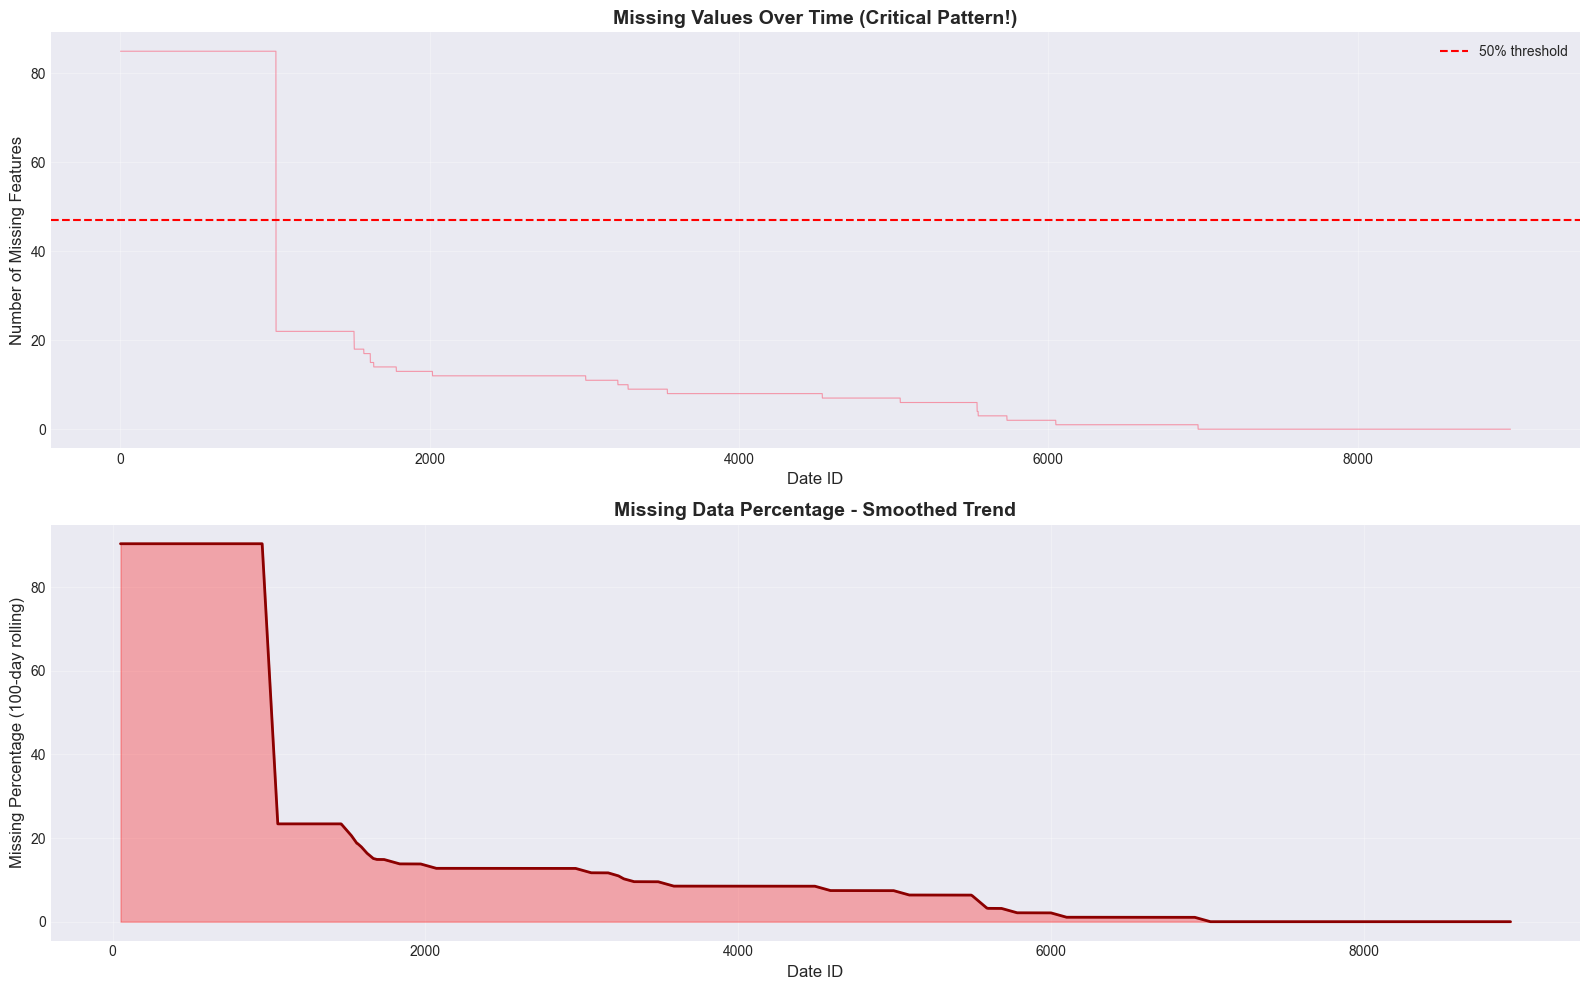


Early period (date_id < 1000): 85.0 missing features on average
Recent period (date_id > 8000): 0.0 missing features on average


In [7]:
# Missing values over time - THIS IS CRITICAL!
train['missing_count'] = train[all_features].isnull().sum(axis=1)

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Plot 1: Missing count over time
axes[0].plot(train['date_id'], train['missing_count'], linewidth=0.8, alpha=0.7)
axes[0].set_xlabel('Date ID', fontsize=12)
axes[0].set_ylabel('Number of Missing Features', fontsize=12)
axes[0].set_title('Missing Values Over Time (Critical Pattern!)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=len(all_features)*0.5, color='r', linestyle='--', label='50% threshold')
axes[0].legend()

# Plot 2: Missing percentage over time (smoothed)
train['missing_pct'] = (train['missing_count'] / len(all_features)) * 100
rolling_missing = train['missing_pct'].rolling(window=100, center=True).mean()
axes[1].plot(train['date_id'], rolling_missing, linewidth=2, color='darkred')
axes[1].fill_between(train['date_id'], 0, rolling_missing, alpha=0.3, color='red')
axes[1].set_xlabel('Date ID', fontsize=12)
axes[1].set_ylabel('Missing Percentage (100-day rolling)', fontsize=12)
axes[1].set_title('Missing Data Percentage - Smoothed Trend', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nEarly period (date_id < 1000): {train[train['date_id'] < 1000]['missing_count'].mean():.1f} missing features on average")
print(f"Recent period (date_id > 8000): {train[train['date_id'] > 8000]['missing_count'].mean():.1f} missing features on average")

In [8]:
# When does data become complete?
complete_threshold = 0.05  # Less than 5% missing
train['is_mostly_complete'] = train['missing_pct'] < (complete_threshold * 100)

first_complete_idx = train[train['is_mostly_complete']].index.min()
first_complete_date = train.loc[first_complete_idx, 'date_id'] if pd.notna(first_complete_idx) else None

if first_complete_date:
    print(f"\n{'='*80}")
    print(f"DATA COMPLETENESS MILESTONE")
    print(f"{'='*80}")
    print(f"First date_id with <{complete_threshold*100}% missing: {first_complete_date}")
    print(f"This represents {len(train[train['date_id'] >= first_complete_date])} trading days")
    print(f"Percentage of total data: {len(train[train['date_id'] >= first_complete_date])/len(train)*100:.1f}%")
    print(f"\nRECOMMENDATION: Consider training only on date_id >= {first_complete_date} for initial models")
else:
    print("No fully complete periods found - all periods have some missing data")


DATA COMPLETENESS MILESTONE
First date_id with <5.0% missing: 5540
This represents 3450 trading days
Percentage of total data: 38.4%

RECOMMENDATION: Consider training only on date_id >= 5540 for initial models


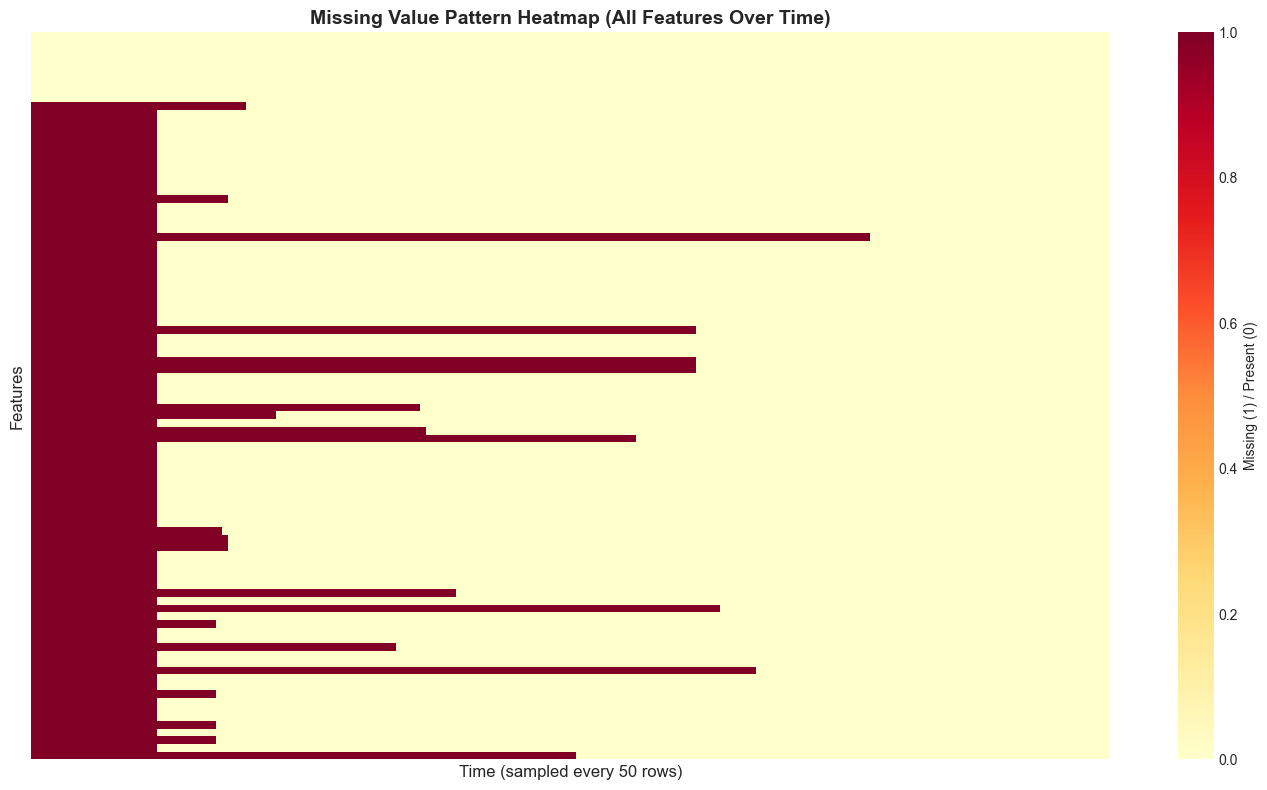

In [9]:
# Heatmap of missing values by feature category
fig, ax = plt.subplots(figsize=(14, 8))

# Sample every 50 rows to make visualization clearer
sample_indices = range(0, len(train), 50)
missing_matrix = train.loc[sample_indices, all_features].isnull().T

sns.heatmap(missing_matrix, cbar=True, cmap='YlOrRd', 
            yticklabels=False, xticklabels=False,
            cbar_kws={'label': 'Missing (1) / Present (0)'})
ax.set_xlabel('Time (sampled every 50 rows)', fontsize=12)
ax.set_ylabel('Features', fontsize=12)
ax.set_title('Missing Value Pattern Heatmap (All Features Over Time)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

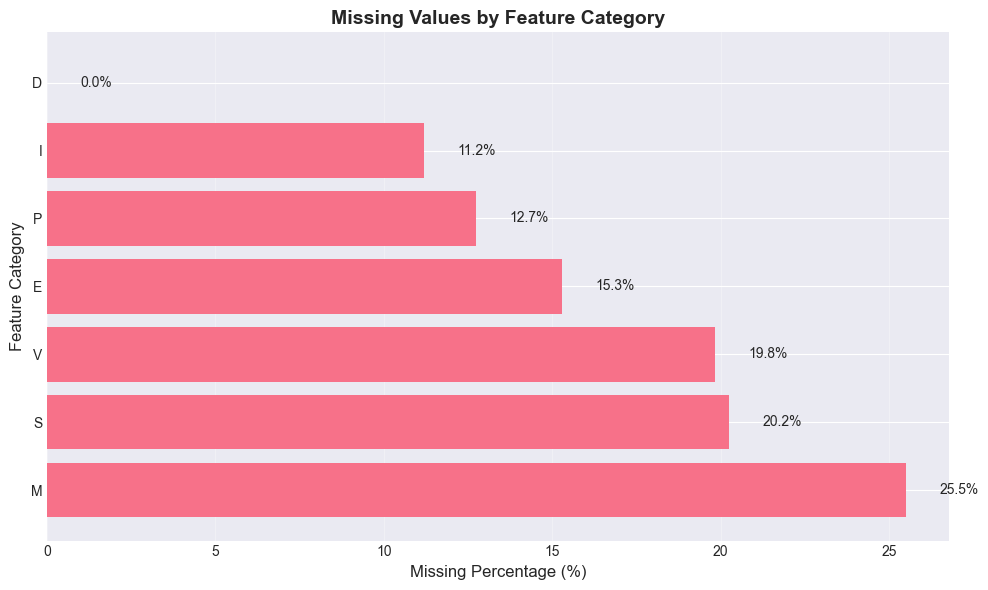


Missing Values by Category:
Category  Missing %
       M  25.493758
       S  20.242862
       V  19.825447
       E  15.278643
       P  12.738941
       I  11.190211
       D   0.000000


In [10]:
# Missing values by feature category
category_missing = {}
for cat, feats in feature_categories.items():
    if feats:  # Only if category has features
        category_missing[cat] = train[feats].isnull().mean().mean() * 100

category_missing_df = pd.DataFrame({
    'Category': list(category_missing.keys()),
    'Missing %': list(category_missing.values())
}).sort_values('Missing %', ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(category_missing_df['Category'], category_missing_df['Missing %'])
ax.set_xlabel('Missing Percentage (%)', fontsize=12)
ax.set_ylabel('Feature Category', fontsize=12)
ax.set_title('Missing Values by Feature Category', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Add value labels
for i, (cat, val) in enumerate(zip(category_missing_df['Category'], category_missing_df['Missing %'])):
    ax.text(val + 1, i, f'{val:.1f}%', va='center', fontsize=10)

plt.tight_layout()
plt.show()

print("\nMissing Values by Category:")
print(category_missing_df.to_string(index=False))

## Section 3: Target Variable Analysis

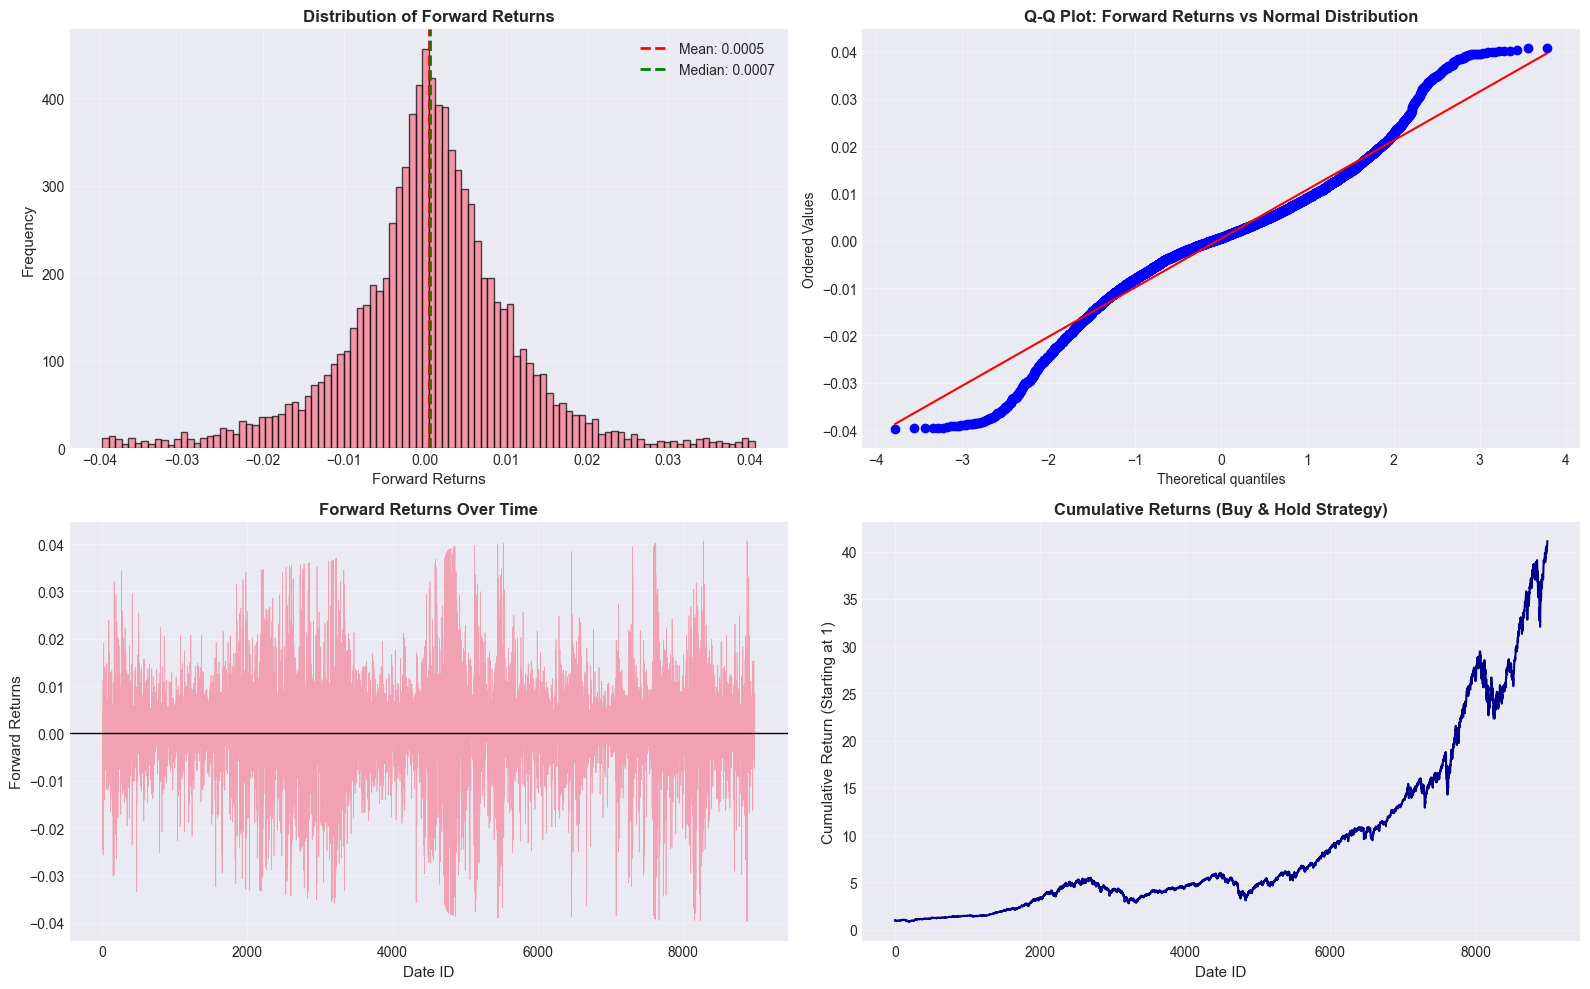

Total return over period: 4012.23%
Annualized return (assuming 252 trading days): 10.98%


In [11]:
# Forward returns distribution
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Histogram
axes[0, 0].hist(train['forward_returns'].dropna(), bins=100, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(train['forward_returns'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {train["forward_returns"].mean():.4f}')
axes[0, 0].axvline(train['forward_returns'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {train["forward_returns"].median():.4f}')
axes[0, 0].set_xlabel('Forward Returns', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('Distribution of Forward Returns', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Q-Q Plot
stats.probplot(train['forward_returns'].dropna(), dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Q-Q Plot: Forward Returns vs Normal Distribution', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Time series
axes[1, 0].plot(train['date_id'], train['forward_returns'], linewidth=0.5, alpha=0.6)
axes[1, 0].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[1, 0].set_xlabel('Date ID', fontsize=11)
axes[1, 0].set_ylabel('Forward Returns', fontsize=11)
axes[1, 0].set_title('Forward Returns Over Time', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Cumulative returns
cumulative_returns = (1 + train['forward_returns']).cumprod()
axes[1, 1].plot(train['date_id'], cumulative_returns, linewidth=1.5, color='darkblue')
axes[1, 1].set_xlabel('Date ID', fontsize=11)
axes[1, 1].set_ylabel('Cumulative Return (Starting at 1)', fontsize=11)
axes[1, 1].set_title('Cumulative Returns (Buy & Hold Strategy)', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Total return over period: {(cumulative_returns.iloc[-1] - 1) * 100:.2f}%")
print(f"Annualized return (assuming 252 trading days): {((cumulative_returns.iloc[-1] ** (252/len(train))) - 1) * 100:.2f}%")

In [12]:
# Statistical properties
returns = train['forward_returns'].dropna()

print("=" * 80)
print("FORWARD RETURNS - STATISTICAL PROPERTIES")
print("=" * 80)
print(f"\nMean: {returns.mean():.6f}")
print(f"Median: {returns.median():.6f}")
print(f"Std Dev: {returns.std():.6f}")
print(f"Skewness: {returns.skew():.4f} {'(left-tailed)' if returns.skew() < 0 else '(right-tailed)'}")
print(f"Kurtosis: {returns.kurtosis():.4f} {'(fat tails!)' if returns.kurtosis() > 3 else '(thin tails)'}")
print(f"\nMin: {returns.min():.6f}")
print(f"Max: {returns.max():.6f}")
print(f"Range: {returns.max() - returns.min():.6f}")
print(f"\nPositive days: {(returns > 0).sum()} ({(returns > 0).mean()*100:.1f}%)")
print(f"Negative days: {(returns < 0).sum()} ({(returns < 0).mean()*100:.1f}%)")

# Annualized metrics
annual_return = returns.mean() * 252
annual_volatility = returns.std() * np.sqrt(252)
sharpe_ratio = annual_return / annual_volatility if annual_volatility != 0 else 0

print(f"\n{'='*80}")
print("ANNUALIZED METRICS (252 trading days)")
print(f"{'='*80}")
print(f"Annualized Return: {annual_return*100:.2f}%")
print(f"Annualized Volatility: {annual_volatility*100:.2f}%")
print(f"Sharpe Ratio (raw): {sharpe_ratio:.4f}")

FORWARD RETURNS - STATISTICAL PROPERTIES

Mean: 0.000469
Median: 0.000659
Std Dev: 0.010551
Skewness: -0.1762 (left-tailed)
Kurtosis: 2.1927 (thin tails)

Min: -0.039754
Max: 0.040661
Range: 0.080415

Positive days: 4848 (53.9%)
Negative days: 4082 (45.4%)

ANNUALIZED METRICS (252 trading days)
Annualized Return: 11.82%
Annualized Volatility: 16.75%
Sharpe Ratio (raw): 0.7060


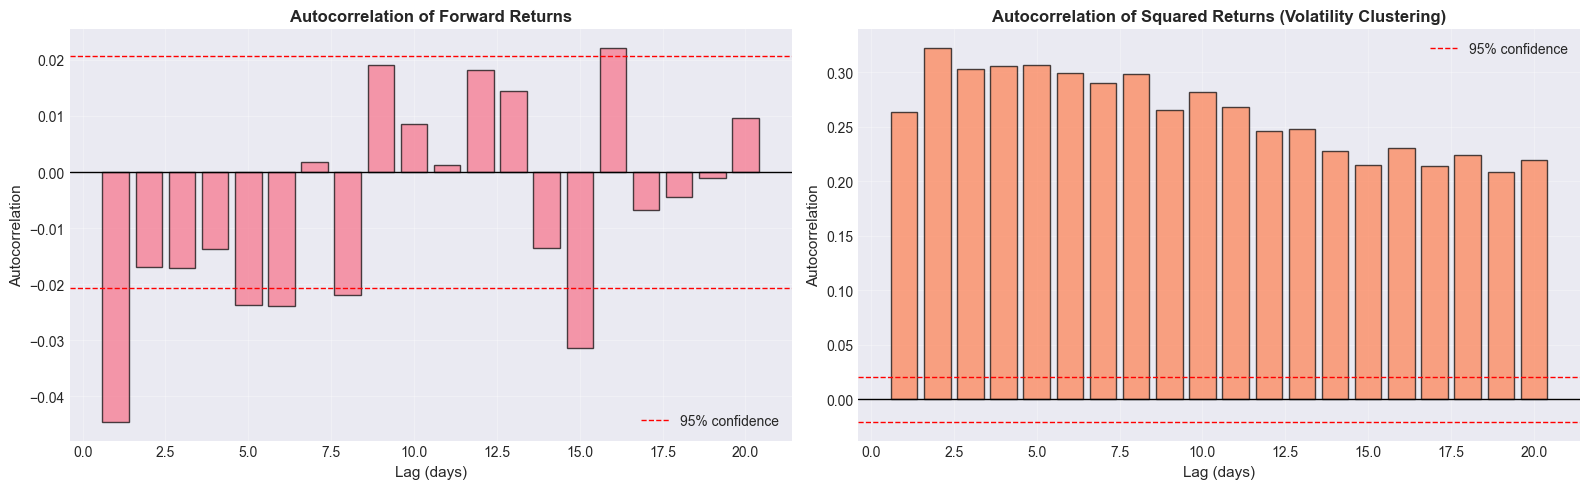


Lag-1 autocorrelation: -0.0445
Lag-1 volatility autocorrelation: 0.2632

Interpretation:
  - Returns autocorr ~0: Returns are mostly random (efficient market)
  - Volatility autocorr >0: Volatility clustering exists (high vol follows high vol)


In [13]:
# Autocorrelation analysis
from scipy.stats import pearsonr

lags = range(1, 21)
autocorrs = []
for lag in lags:
    corr, _ = pearsonr(returns[:-lag], returns[lag:])
    autocorrs.append(corr)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Autocorrelation plot
axes[0].bar(lags, autocorrs, alpha=0.7, edgecolor='black')
axes[0].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[0].axhline(y=1.96/np.sqrt(len(returns)), color='red', linestyle='--', linewidth=1, label='95% confidence')
axes[0].axhline(y=-1.96/np.sqrt(len(returns)), color='red', linestyle='--', linewidth=1)
axes[0].set_xlabel('Lag (days)', fontsize=11)
axes[0].set_ylabel('Autocorrelation', fontsize=11)
axes[0].set_title('Autocorrelation of Forward Returns', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Volatility clustering - squared returns autocorrelation
squared_returns = returns ** 2
vol_autocorrs = []
for lag in lags:
    corr, _ = pearsonr(squared_returns[:-lag], squared_returns[lag:])
    vol_autocorrs.append(corr)

axes[1].bar(lags, vol_autocorrs, alpha=0.7, edgecolor='black', color='coral')
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[1].axhline(y=1.96/np.sqrt(len(squared_returns)), color='red', linestyle='--', linewidth=1, label='95% confidence')
axes[1].axhline(y=-1.96/np.sqrt(len(squared_returns)), color='red', linestyle='--', linewidth=1)
axes[1].set_xlabel('Lag (days)', fontsize=11)
axes[1].set_ylabel('Autocorrelation', fontsize=11)
axes[1].set_title('Autocorrelation of Squared Returns (Volatility Clustering)', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nLag-1 autocorrelation: {autocorrs[0]:.4f}")
print(f"Lag-1 volatility autocorrelation: {vol_autocorrs[0]:.4f}")
print(f"\nInterpretation:")
print(f"  - Returns autocorr ~0: Returns are mostly random (efficient market)")
print(f"  - Volatility autocorr >0: Volatility clustering exists (high vol follows high vol)")

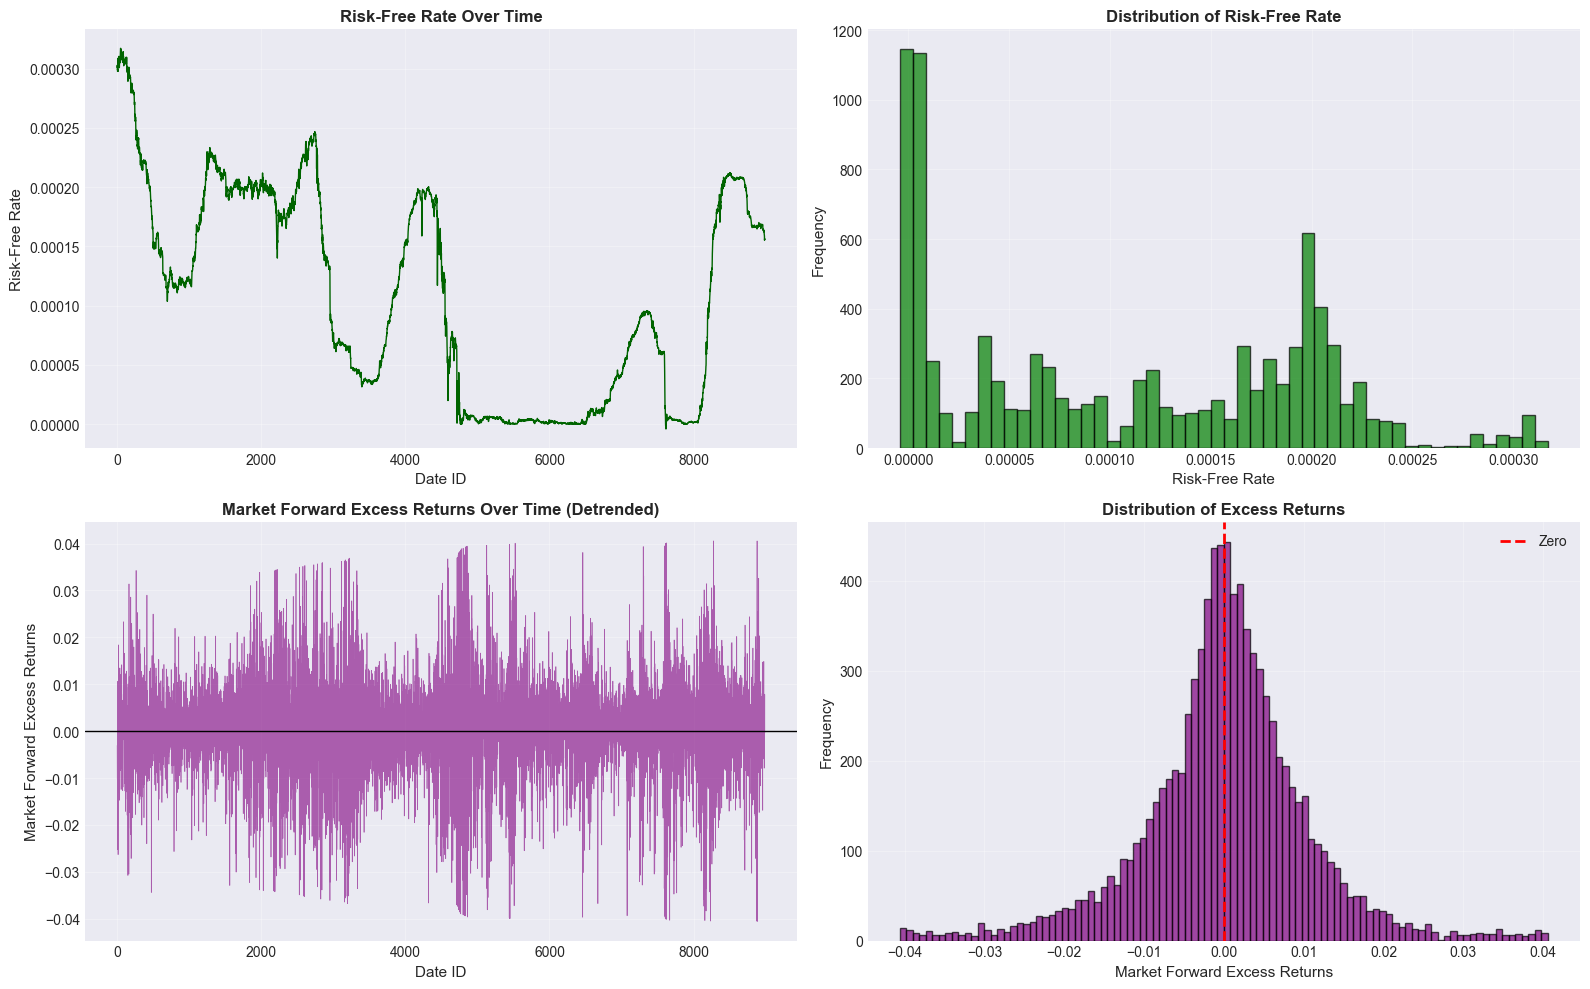

In [14]:
# Risk-free rate and excess returns
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Risk-free rate over time
axes[0, 0].plot(train['date_id'], train['risk_free_rate'], linewidth=1, color='darkgreen')
axes[0, 0].set_xlabel('Date ID', fontsize=11)
axes[0, 0].set_ylabel('Risk-Free Rate', fontsize=11)
axes[0, 0].set_title('Risk-Free Rate Over Time', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Risk-free rate distribution
axes[0, 1].hist(train['risk_free_rate'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='green')
axes[0, 1].set_xlabel('Risk-Free Rate', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_title('Distribution of Risk-Free Rate', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Market forward excess returns over time
axes[1, 0].plot(train['date_id'], train['market_forward_excess_returns'], linewidth=0.5, alpha=0.6, color='purple')
axes[1, 0].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[1, 0].set_xlabel('Date ID', fontsize=11)
axes[1, 0].set_ylabel('Market Forward Excess Returns', fontsize=11)
axes[1, 0].set_title('Market Forward Excess Returns Over Time (Detrended)', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Excess returns distribution
axes[1, 1].hist(train['market_forward_excess_returns'].dropna(), bins=100, edgecolor='black', alpha=0.7, color='purple')
axes[1, 1].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero')
axes[1, 1].set_xlabel('Market Forward Excess Returns', fontsize=11)
axes[1, 1].set_ylabel('Frequency', fontsize=11)
axes[1, 1].set_title('Distribution of Excess Returns', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

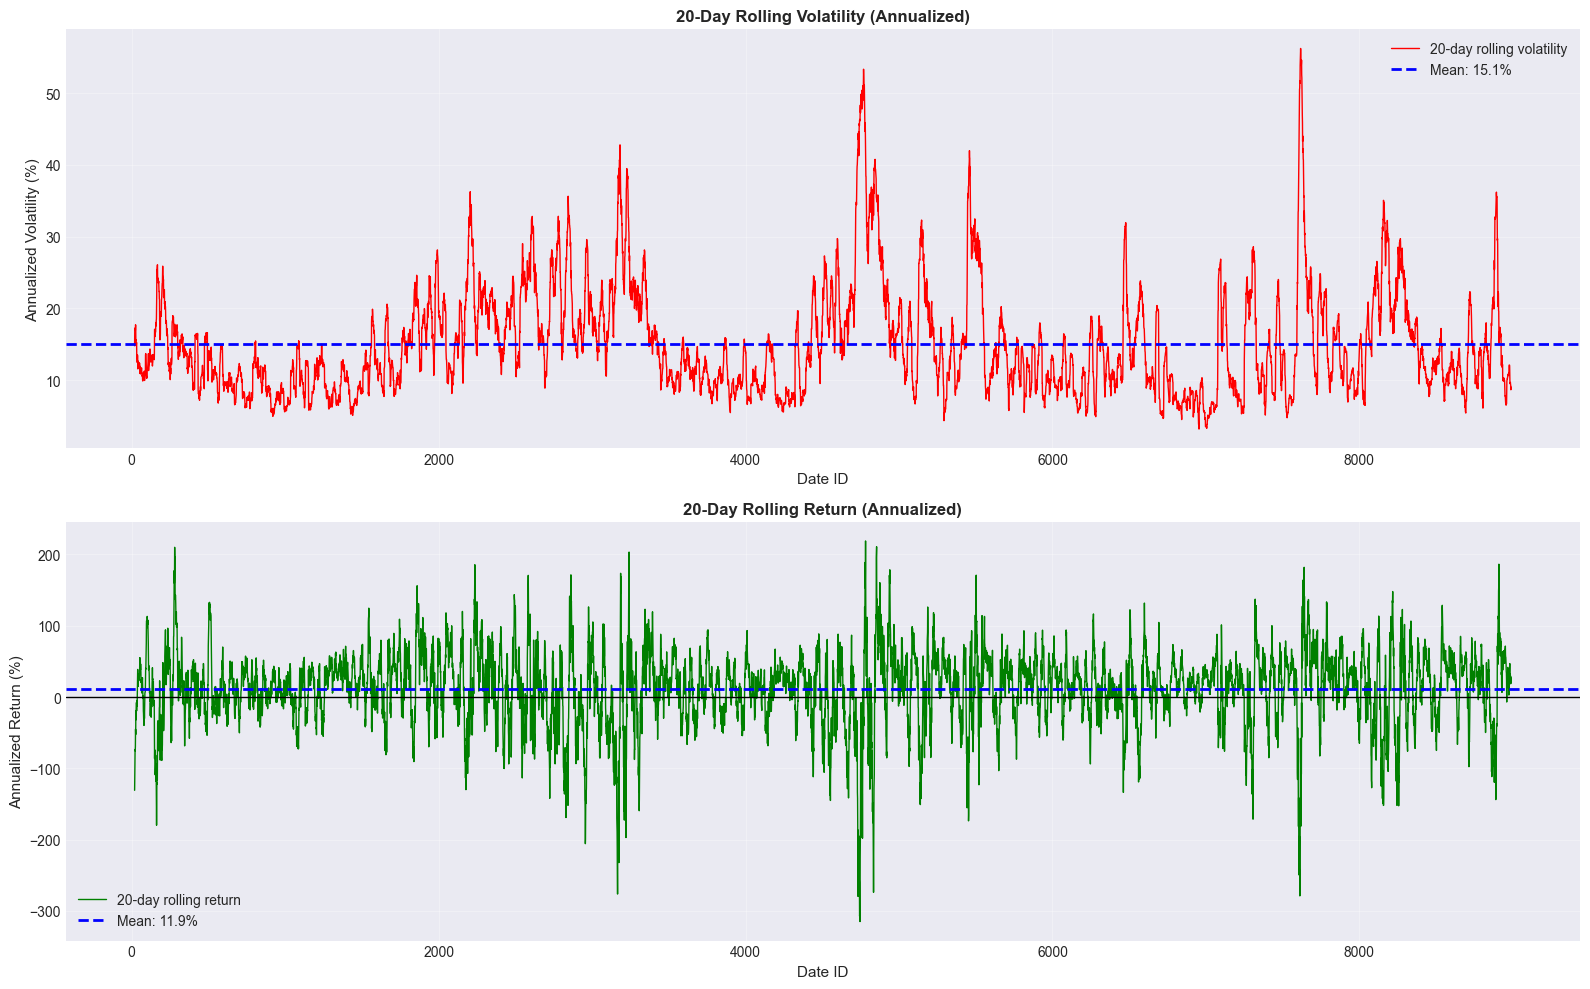

Average annualized volatility: 15.07%
Max annualized volatility: 56.24%
Min annualized volatility: 3.19%


In [15]:
# Rolling volatility analysis
window = 20  # 20-day rolling window

train['rolling_vol'] = train['forward_returns'].rolling(window=window).std() * np.sqrt(252) * 100
train['rolling_return'] = train['forward_returns'].rolling(window=window).mean() * 252 * 100

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Rolling volatility
axes[0].plot(train['date_id'], train['rolling_vol'], linewidth=1, color='red', label=f'{window}-day rolling volatility')
axes[0].axhline(y=train['rolling_vol'].mean(), color='blue', linestyle='--', linewidth=2, label=f'Mean: {train["rolling_vol"].mean():.1f}%')
axes[0].set_xlabel('Date ID', fontsize=11)
axes[0].set_ylabel('Annualized Volatility (%)', fontsize=11)
axes[0].set_title(f'{window}-Day Rolling Volatility (Annualized)', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Rolling return
axes[1].plot(train['date_id'], train['rolling_return'], linewidth=1, color='green', label=f'{window}-day rolling return')
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[1].axhline(y=train['rolling_return'].mean(), color='blue', linestyle='--', linewidth=2, label=f'Mean: {train["rolling_return"].mean():.1f}%')
axes[1].set_xlabel('Date ID', fontsize=11)
axes[1].set_ylabel('Annualized Return (%)', fontsize=11)
axes[1].set_title(f'{window}-Day Rolling Return (Annualized)', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Average annualized volatility: {train['rolling_vol'].mean():.2f}%")
print(f"Max annualized volatility: {train['rolling_vol'].max():.2f}%")
print(f"Min annualized volatility: {train['rolling_vol'].min():.2f}%")

## Section 4: Feature Analysis

In [16]:
# Sample representative features from each category
sample_features = {}
for cat, feats in feature_categories.items():
    if feats:
        # Pick first feature from each category
        sample_features[cat] = feats[0]

print("Representative features from each category:")
for cat, feat in sample_features.items():
    print(f"  {cat}: {feat}")

Representative features from each category:
  D: D1
  E: E1
  I: I1
  M: M1
  P: P1
  S: S1
  V: V1


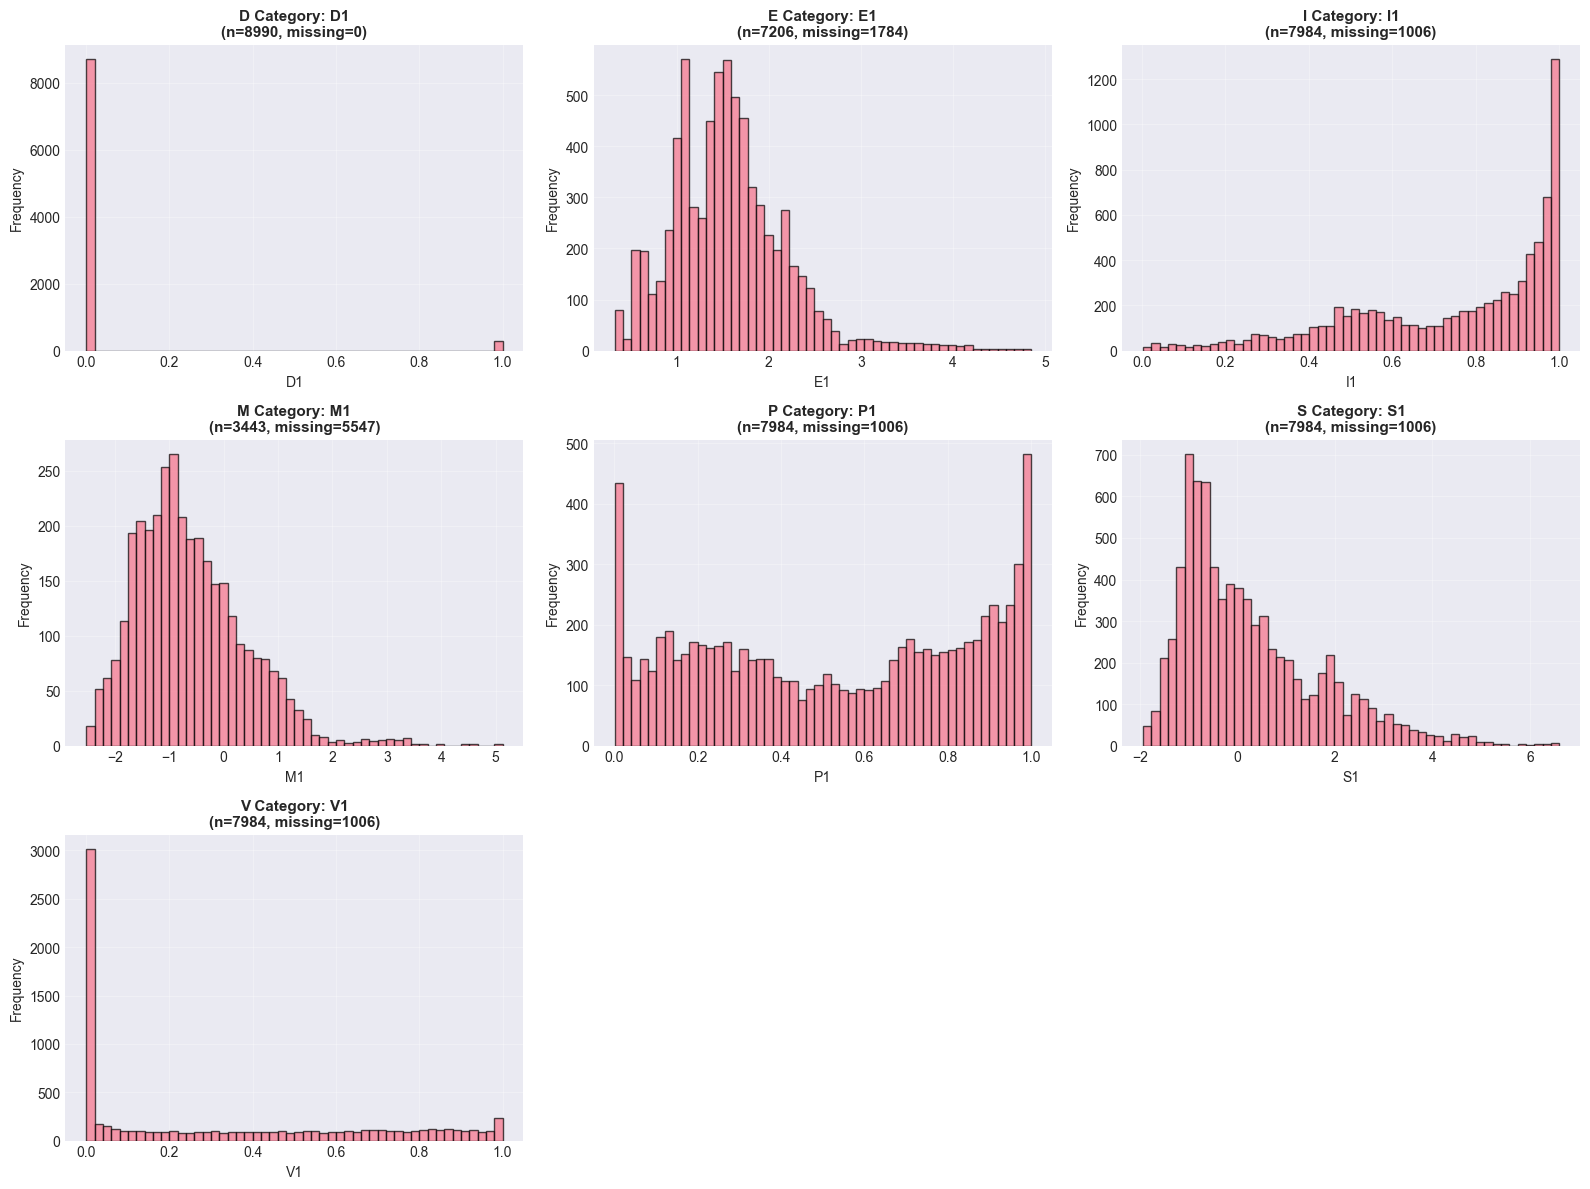

In [17]:
# Distribution of representative features
n_cats = len(sample_features)
n_cols = 3
n_rows = (n_cats + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4))
axes = axes.flatten() if n_cats > 1 else [axes]

for idx, (cat, feat) in enumerate(sample_features.items()):
    data = train[feat].dropna()
    if len(data) > 0:
        axes[idx].hist(data, bins=50, edgecolor='black', alpha=0.7)
        axes[idx].set_xlabel(feat, fontsize=10)
        axes[idx].set_ylabel('Frequency', fontsize=10)
        axes[idx].set_title(f'{cat} Category: {feat}\n(n={len(data)}, missing={train[feat].isnull().sum()})', 
                           fontsize=11, fontweight='bold')
        axes[idx].grid(True, alpha=0.3)

# Hide extra subplots
for idx in range(n_cats, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

TOP 20 FEATURES CORRELATED WITH FORWARD RETURNS

Most Positively Correlated:
V13    0.063071
M1     0.044979
S5     0.040562
D1     0.034180
D2     0.034180
M2     0.033464
V7     0.032736
V10    0.031712
M17    0.024940
D8     0.024739
Name: forward_returns, dtype: float64

Most Negatively Correlated:
P5    -0.022959
I2    -0.023011
M12   -0.023914
M8    -0.023991
P8    -0.026229
E12   -0.029557
E11   -0.030796
E7    -0.032192
S2    -0.037465
M4    -0.066591
Name: forward_returns, dtype: float64


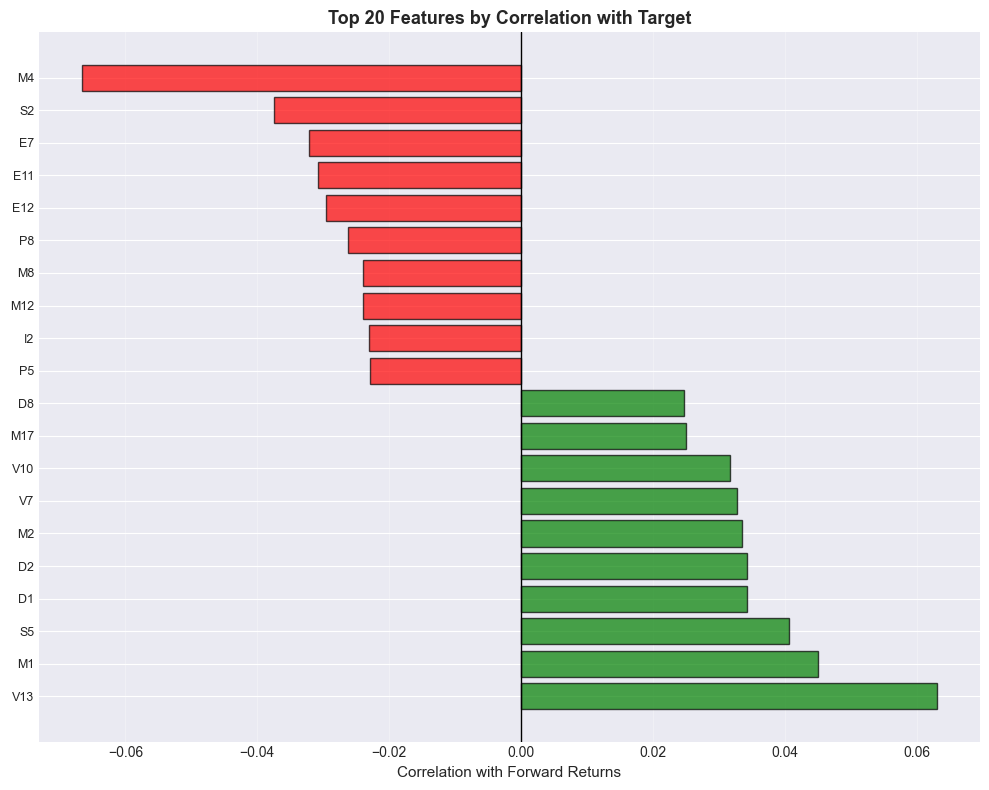

In [18]:
# Correlation with target - find most predictive features
correlations = train[all_features + ['forward_returns']].corr()['forward_returns'].drop('forward_returns').sort_values(ascending=False)

print("=" * 80)
print("TOP 20 FEATURES CORRELATED WITH FORWARD RETURNS")
print("=" * 80)
print("\nMost Positively Correlated:")
print(correlations.head(10))
print("\nMost Negatively Correlated:")
print(correlations.tail(10))

# Visualize top correlations
top_n = 20
top_corrs = pd.concat([correlations.head(top_n//2), correlations.tail(top_n//2)])

fig, ax = plt.subplots(figsize=(10, 8))
colors = ['green' if x > 0 else 'red' for x in top_corrs.values]
ax.barh(range(len(top_corrs)), top_corrs.values, color=colors, alpha=0.7, edgecolor='black')
ax.set_yticks(range(len(top_corrs)))
ax.set_yticklabels(top_corrs.index, fontsize=9)
ax.set_xlabel('Correlation with Forward Returns', fontsize=11)
ax.set_title(f'Top {top_n} Features by Correlation with Target', fontsize=13, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

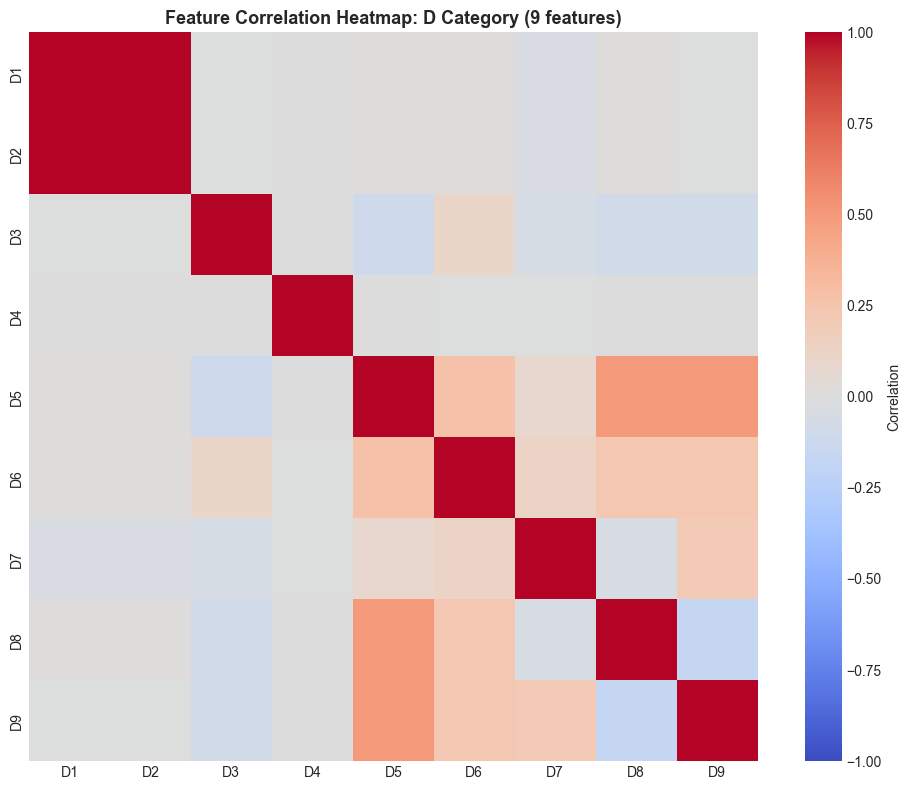


D Category - Highly correlated pairs (|r| > 0.9):
  D1 <-> D2: 1.000



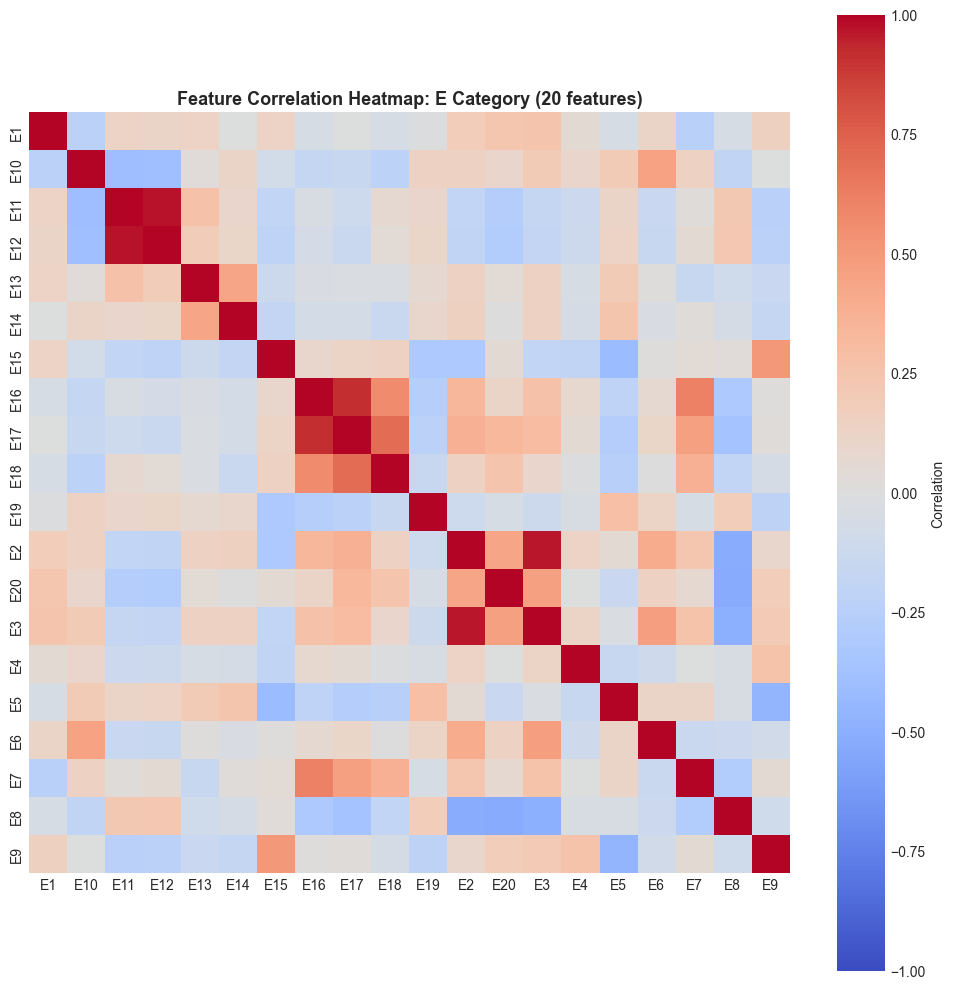


E Category - Highly correlated pairs (|r| > 0.9):
  E11 <-> E12: 0.974
  E16 <-> E17: 0.918
  E2 <-> E3: 0.961



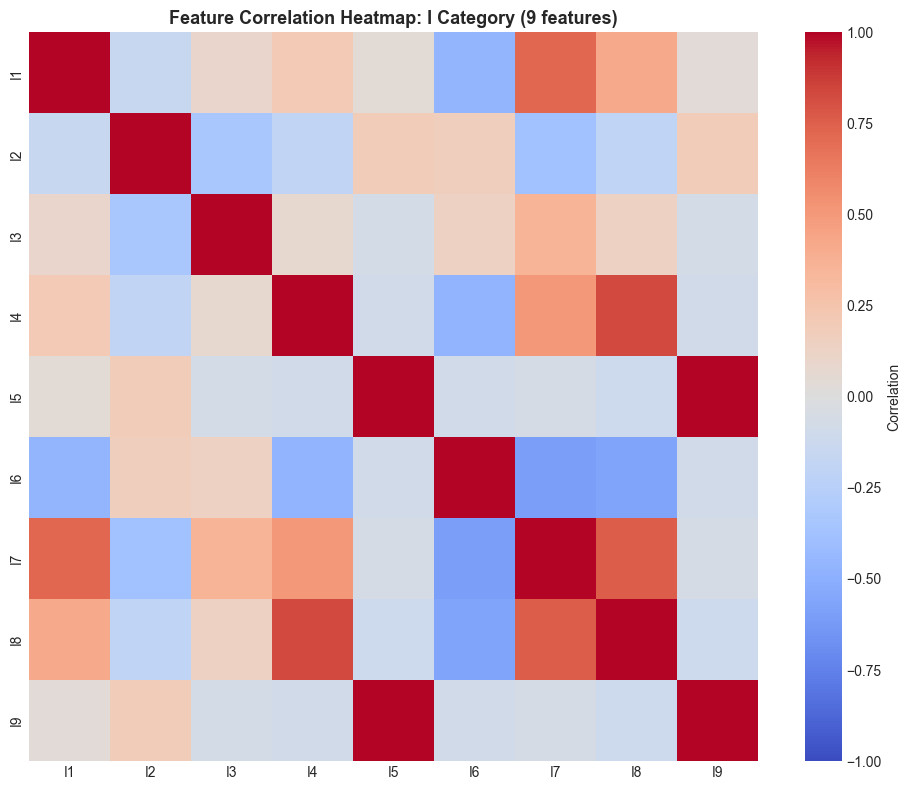


I Category - Highly correlated pairs (|r| > 0.9):
  I5 <-> I9: 1.000



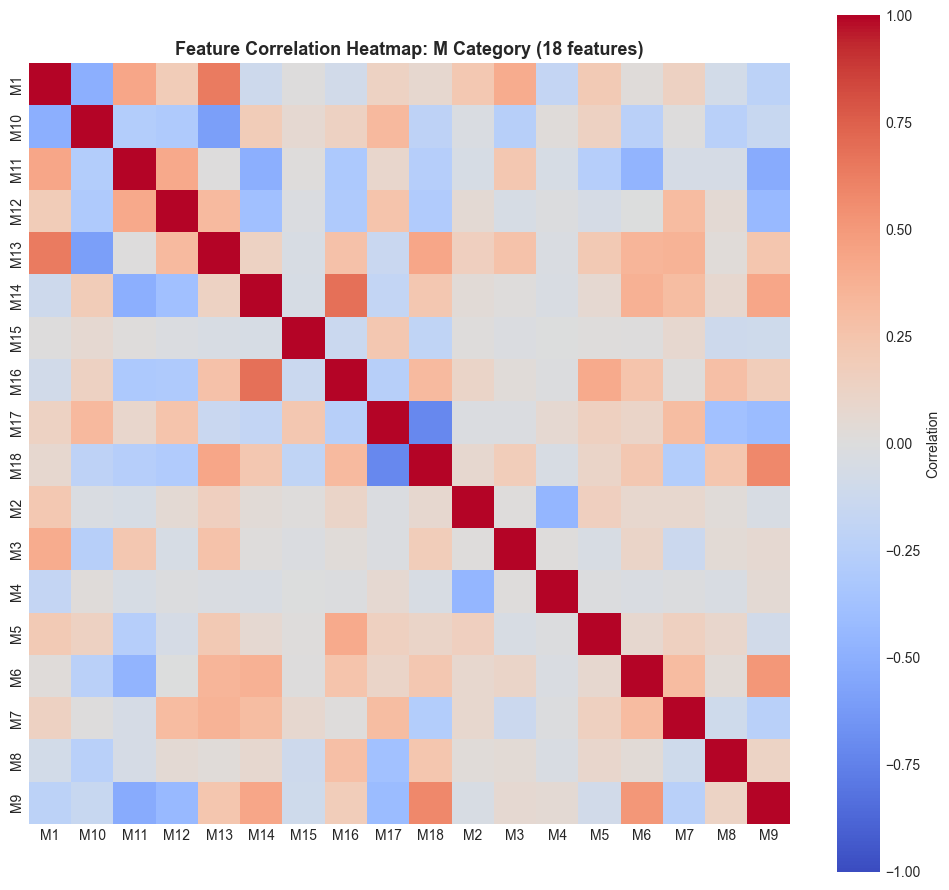

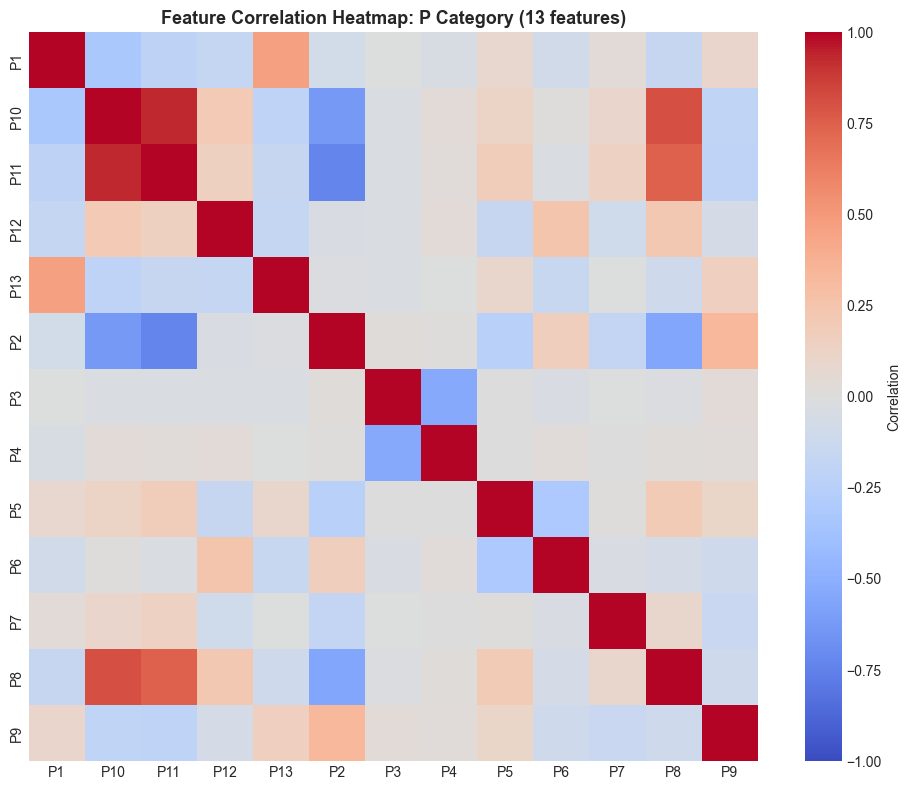


P Category - Highly correlated pairs (|r| > 0.9):
  P10 <-> P11: 0.936



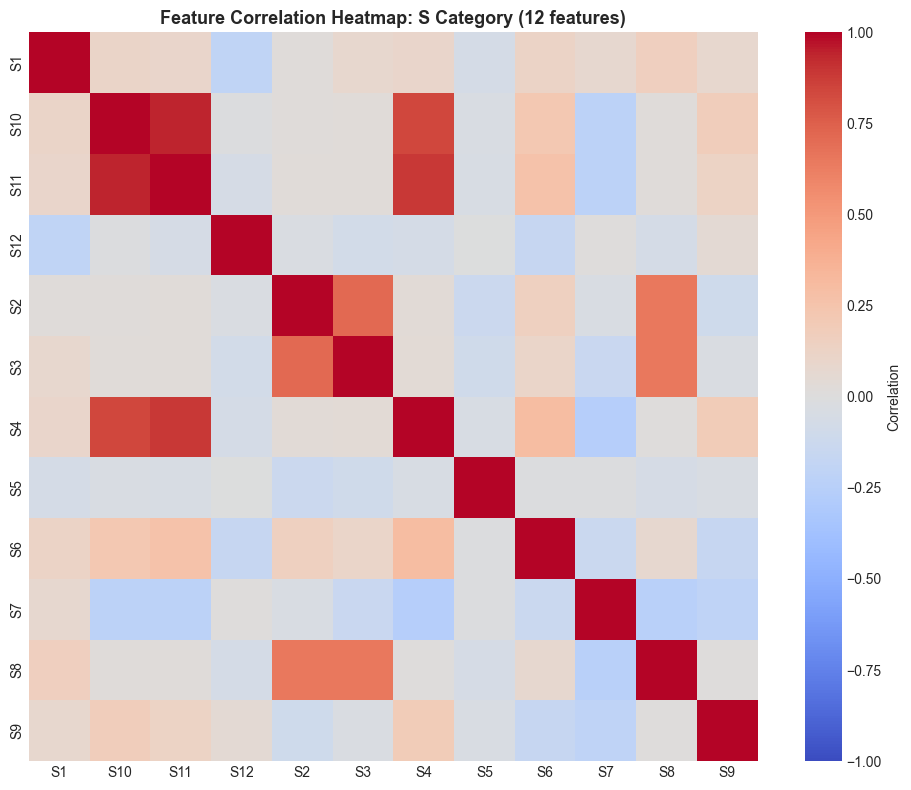


S Category - Highly correlated pairs (|r| > 0.9):
  S10 <-> S11: 0.944



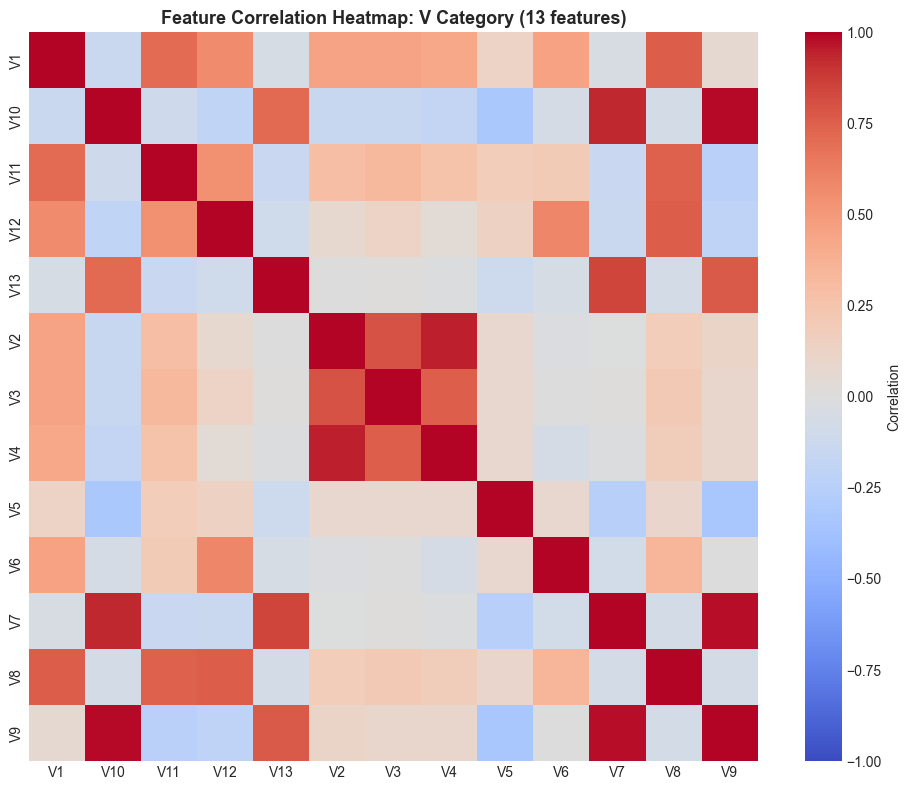


V Category - Highly correlated pairs (|r| > 0.9):
  V10 <-> V7: 0.934
  V10 <-> V9: 0.985
  V2 <-> V4: 0.953
  V7 <-> V9: 0.978



In [19]:
# Feature correlation heatmap - within each category
for cat, feats in feature_categories.items():
    if len(feats) > 1:  # Only if category has multiple features
        corr_matrix = train[feats].corr()
        
        fig, ax = plt.subplots(figsize=(max(10, len(feats)*0.5), max(8, len(feats)*0.5)))
        sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, 
                    vmin=-1, vmax=1, square=True, cbar_kws={'label': 'Correlation'})
        ax.set_title(f'Feature Correlation Heatmap: {cat} Category ({len(feats)} features)', 
                    fontsize=13, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        # Find highly correlated pairs
        high_corr_pairs = []
        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                if abs(corr_matrix.iloc[i, j]) > 0.9:
                    high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))
        
        if high_corr_pairs:
            print(f"\n{cat} Category - Highly correlated pairs (|r| > 0.9):")
            for f1, f2, corr in high_corr_pairs:
                print(f"  {f1} <-> {f2}: {corr:.3f}")
        print()

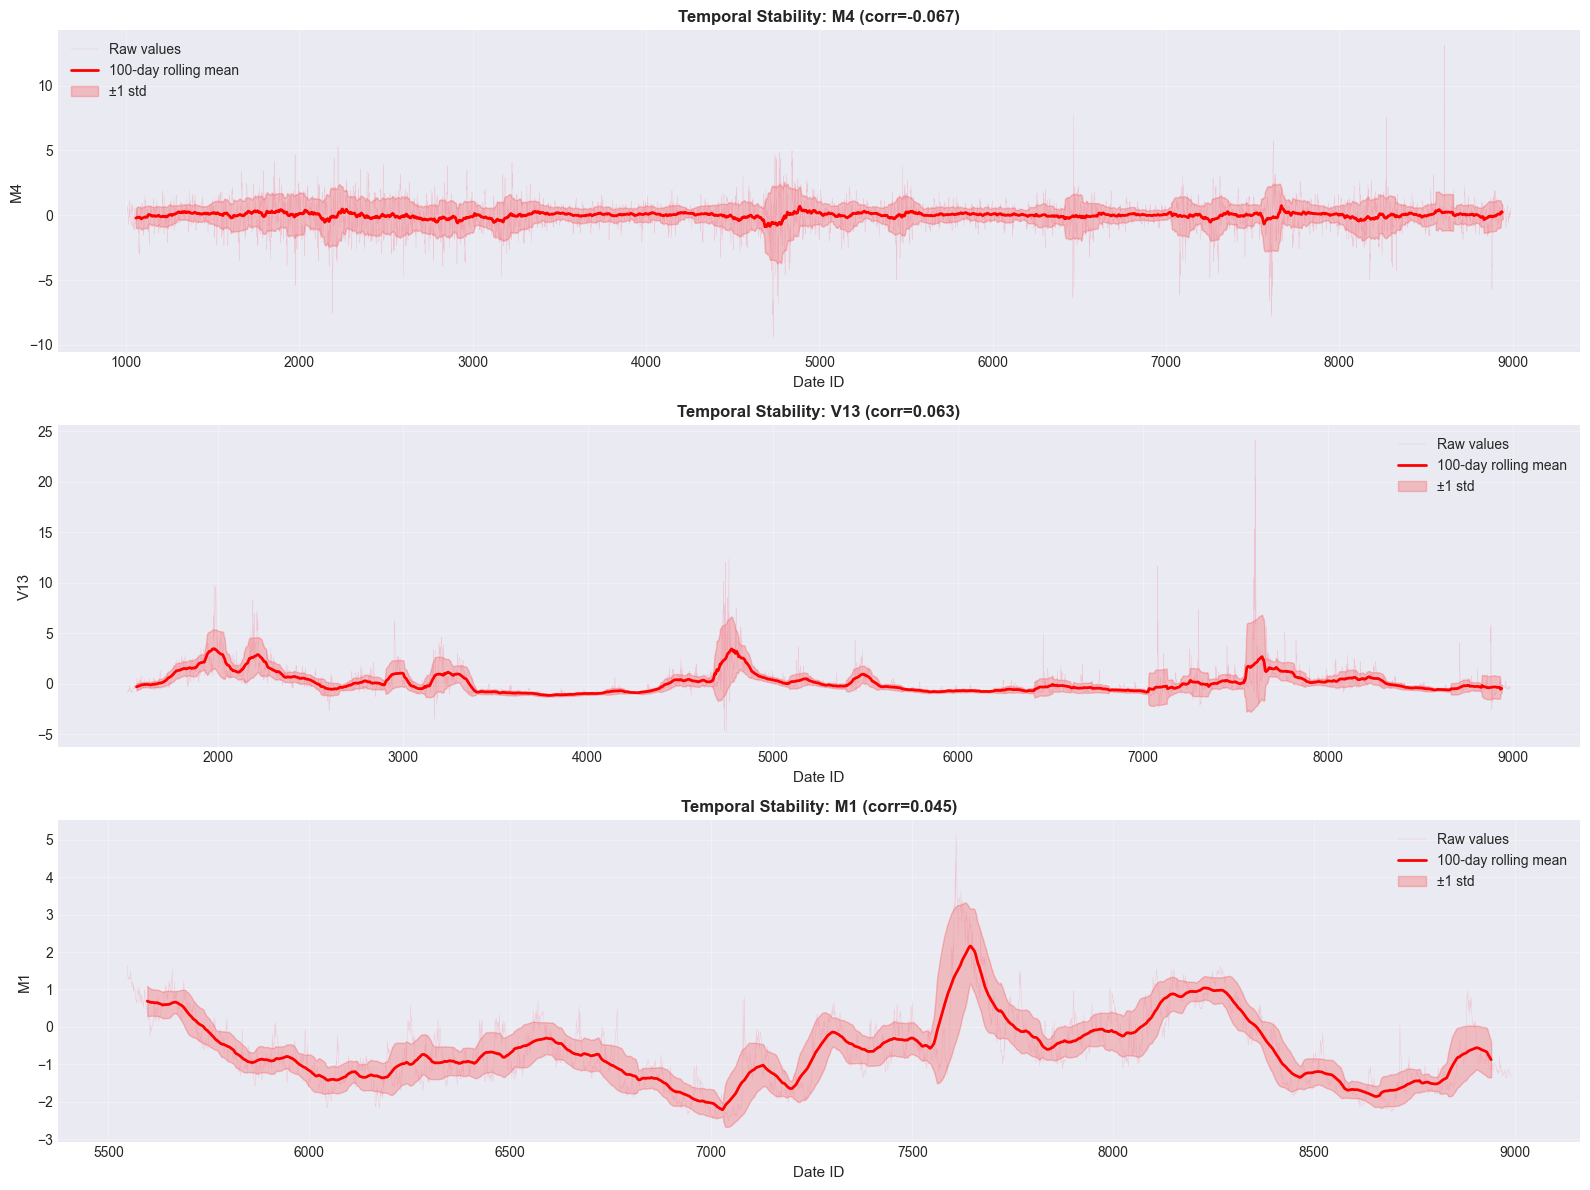

In [20]:
# Feature stability over time - do feature distributions change?
# Pick top 3 most correlated features and check their stability
top_features = correlations.abs().nlargest(3).index.tolist()

fig, axes = plt.subplots(len(top_features), 1, figsize=(16, 4*len(top_features)))
if len(top_features) == 1:
    axes = [axes]

for idx, feat in enumerate(top_features):
    # Rolling mean and std
    rolling_mean = train[feat].rolling(window=100, center=True).mean()
    rolling_std = train[feat].rolling(window=100, center=True).std()
    
    axes[idx].plot(train['date_id'], train[feat], linewidth=0.3, alpha=0.3, label='Raw values')
    axes[idx].plot(train['date_id'], rolling_mean, linewidth=2, color='red', label='100-day rolling mean')
    axes[idx].fill_between(train['date_id'], 
                           rolling_mean - rolling_std, 
                           rolling_mean + rolling_std, 
                           alpha=0.2, color='red', label='±1 std')
    axes[idx].set_xlabel('Date ID', fontsize=11)
    axes[idx].set_ylabel(feat, fontsize=11)
    axes[idx].set_title(f'Temporal Stability: {feat} (corr={correlations[feat]:.3f})', 
                       fontsize=12, fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Section 5: Time Series Properties

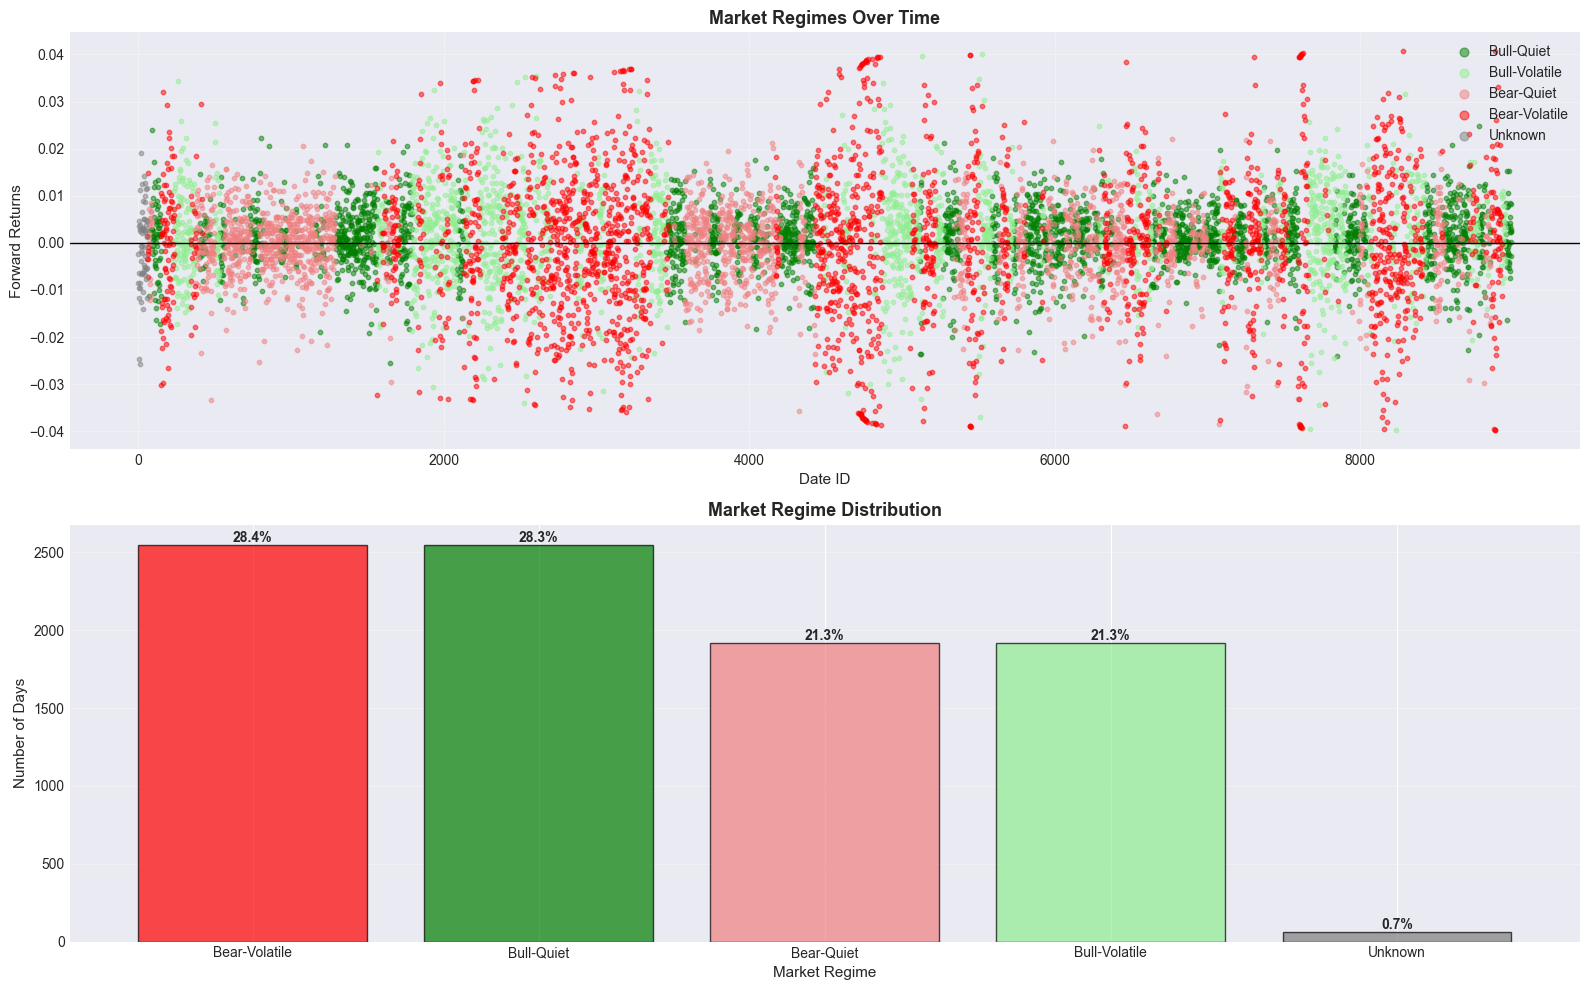


Market Regime Statistics:
market_regime
Bear-Volatile    2549
Bull-Quiet       2548
Bear-Quiet       1917
Bull-Volatile    1917
Unknown            59
Name: count, dtype: int64


In [21]:
# Market regime identification using rolling statistics
window = 60  # 60-day window for regime classification

train['regime_return'] = train['forward_returns'].rolling(window=window).mean()
train['regime_vol'] = train['forward_returns'].rolling(window=window).std()

# Classify regimes
return_median = train['regime_return'].median()
vol_median = train['regime_vol'].median()

conditions = [
    (train['regime_return'] > return_median) & (train['regime_vol'] < vol_median),
    (train['regime_return'] > return_median) & (train['regime_vol'] >= vol_median),
    (train['regime_return'] <= return_median) & (train['regime_vol'] < vol_median),
    (train['regime_return'] <= return_median) & (train['regime_vol'] >= vol_median),
]
choices = ['Bull-Quiet', 'Bull-Volatile', 'Bear-Quiet', 'Bear-Volatile']
train['market_regime'] = np.select(conditions, choices, default='Unknown')

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Regime over time
regime_colors = {'Bull-Quiet': 'green', 'Bull-Volatile': 'lightgreen', 
                 'Bear-Quiet': 'lightcoral', 'Bear-Volatile': 'red', 'Unknown': 'gray'}

for regime in ['Bull-Quiet', 'Bull-Volatile', 'Bear-Quiet', 'Bear-Volatile', 'Unknown']:
    mask = train['market_regime'] == regime
    axes[0].scatter(train.loc[mask, 'date_id'], train.loc[mask, 'forward_returns'], 
                   c=regime_colors[regime], label=regime, alpha=0.5, s=10)

axes[0].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[0].set_xlabel('Date ID', fontsize=11)
axes[0].set_ylabel('Forward Returns', fontsize=11)
axes[0].set_title('Market Regimes Over Time', fontsize=13, fontweight='bold')
axes[0].legend(loc='best', markerscale=2)
axes[0].grid(True, alpha=0.3)

# Regime distribution
regime_counts = train['market_regime'].value_counts()
axes[1].bar(regime_counts.index, regime_counts.values, 
           color=[regime_colors[r] for r in regime_counts.index], 
           edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Market Regime', fontsize=11)
axes[1].set_ylabel('Number of Days', fontsize=11)
axes[1].set_title('Market Regime Distribution', fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Add percentage labels
for i, (regime, count) in enumerate(regime_counts.items()):
    pct = count / len(train) * 100
    axes[1].text(i, count, f'{pct:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nMarket Regime Statistics:")
print(regime_counts)

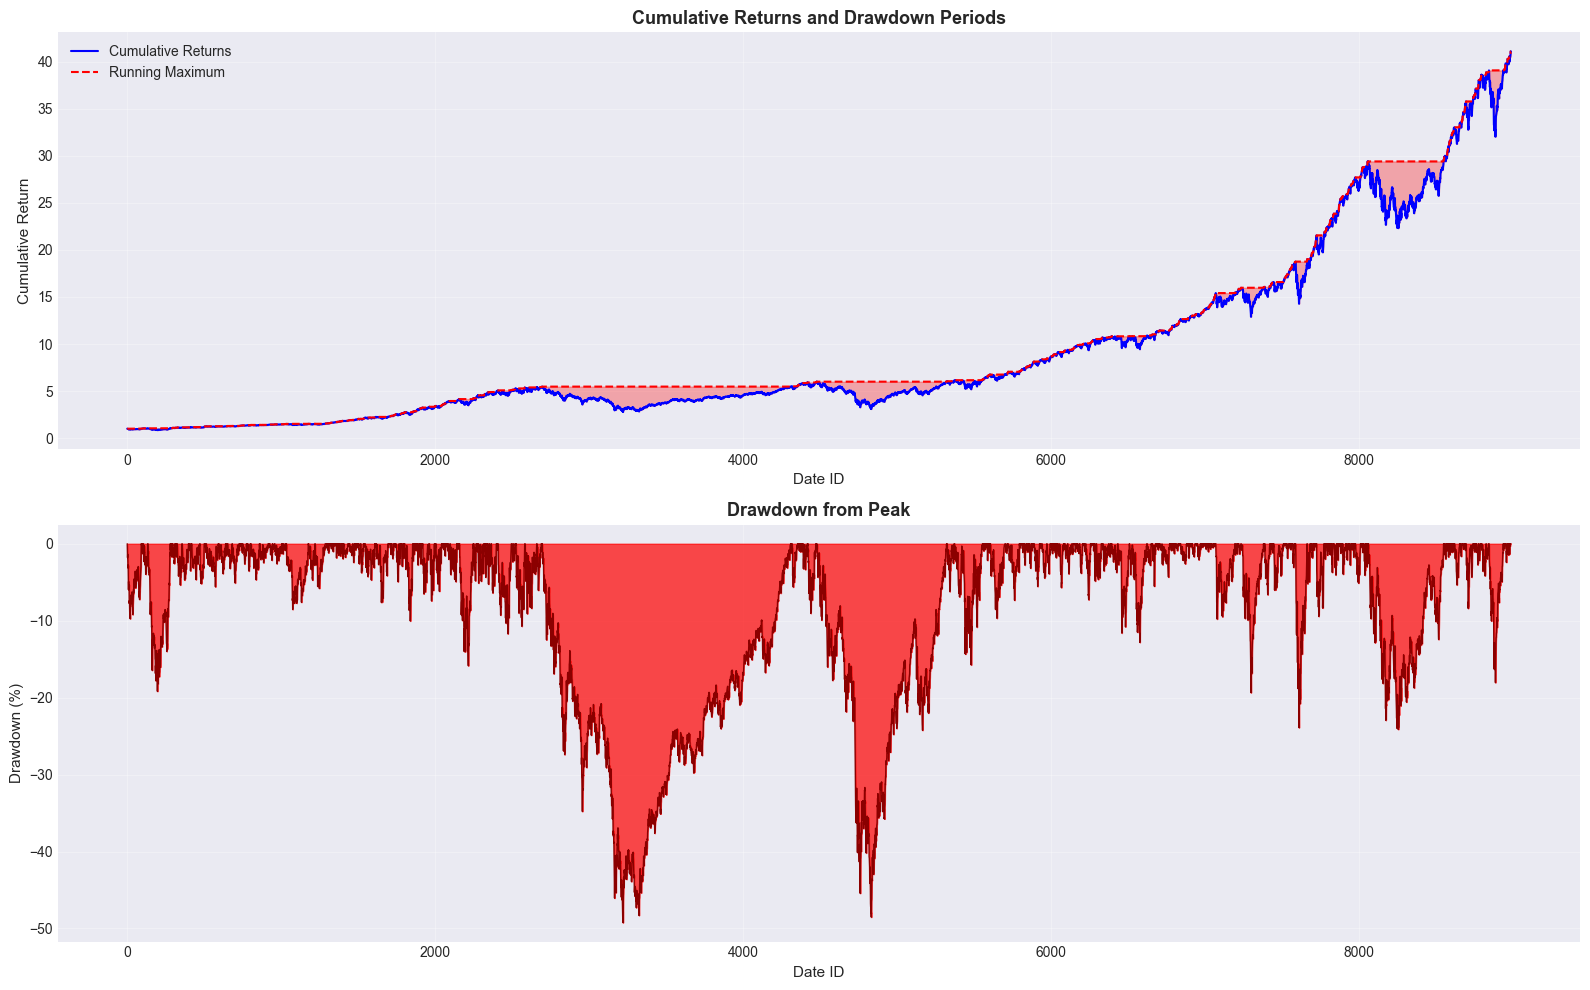


Maximum Drawdown: -49.24%
Maximum Drawdown Date ID: 3221

Top 5 Worst Drawdowns:
  Date ID 3221: -49.24%
  Date ID 3219: -48.57%
  Date ID 4834: -48.53%
  Date ID 3325: -48.31%
  Date ID 4832: -48.01%


In [22]:
# Drawdown analysis
cumulative = (1 + train['forward_returns']).cumprod()
running_max = cumulative.cummax()
drawdown = (cumulative - running_max) / running_max * 100

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Cumulative returns with drawdown shading
axes[0].plot(train['date_id'], cumulative, linewidth=1.5, color='blue', label='Cumulative Returns')
axes[0].plot(train['date_id'], running_max, linewidth=1.5, color='red', linestyle='--', label='Running Maximum')
axes[0].fill_between(train['date_id'], cumulative, running_max, alpha=0.3, color='red')
axes[0].set_xlabel('Date ID', fontsize=11)
axes[0].set_ylabel('Cumulative Return', fontsize=11)
axes[0].set_title('Cumulative Returns and Drawdown Periods', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Drawdown over time
axes[1].fill_between(train['date_id'], 0, drawdown, alpha=0.7, color='red')
axes[1].plot(train['date_id'], drawdown, linewidth=1, color='darkred')
axes[1].set_xlabel('Date ID', fontsize=11)
axes[1].set_ylabel('Drawdown (%)', fontsize=11)
axes[1].set_title('Drawdown from Peak', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nMaximum Drawdown: {drawdown.min():.2f}%")
print(f"Maximum Drawdown Date ID: {train.loc[drawdown.idxmin(), 'date_id']}")

# Identify top 5 worst drawdown periods
drawdown_sorted = drawdown.sort_values().head(5)
print("\nTop 5 Worst Drawdowns:")
for idx, dd in drawdown_sorted.items():
    date_id = train.loc[idx, 'date_id']
    print(f"  Date ID {date_id}: {dd:.2f}%")


Longest winning streak: 14 days
Longest losing streak: 8 days


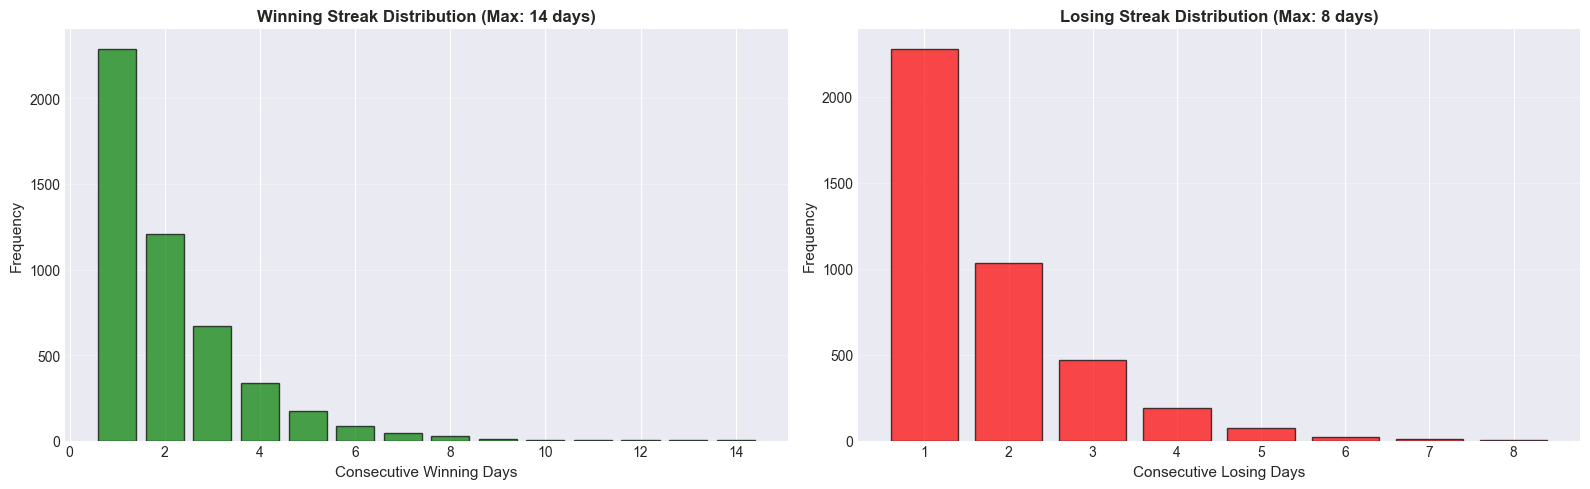

In [23]:
# Win/Loss streak analysis
train['is_positive'] = (train['forward_returns'] > 0).astype(int)
train['streak'] = train['is_positive'].groupby((train['is_positive'] != train['is_positive'].shift()).cumsum()).cumsum()
train['is_negative'] = (train['forward_returns'] < 0).astype(int)
train['loss_streak'] = train['is_negative'].groupby((train['is_negative'] != train['is_negative'].shift()).cumsum()).cumsum()

max_win_streak = train['streak'].max()
max_loss_streak = train['loss_streak'].max()

print(f"\nLongest winning streak: {max_win_streak} days")
print(f"Longest losing streak: {max_loss_streak} days")

# Streak distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Win streaks
win_streaks = train[train['streak'] > 0]['streak'].value_counts().sort_index()
axes[0].bar(win_streaks.index, win_streaks.values, edgecolor='black', alpha=0.7, color='green')
axes[0].set_xlabel('Consecutive Winning Days', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title(f'Winning Streak Distribution (Max: {max_win_streak} days)', fontsize=12, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Loss streaks
loss_streaks = train[train['loss_streak'] > 0]['loss_streak'].value_counts().sort_index()
axes[1].bar(loss_streaks.index, loss_streaks.values, edgecolor='black', alpha=0.7, color='red')
axes[1].set_xlabel('Consecutive Losing Days', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title(f'Losing Streak Distribution (Max: {max_loss_streak} days)', fontsize=12, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Section 6: Baseline Strategy Analysis

In [24]:
# Implement the competition metric
MIN_INVESTMENT = 0
MAX_INVESTMENT = 2

def calculate_competition_score(returns, risk_free_rate, position):
    """
    Calculate the competition metric (volatility-adjusted Sharpe ratio).
    
    Args:
        returns: Forward returns (pd.Series)
        risk_free_rate: Risk-free rate (pd.Series)
        position: Allocation to market, 0 to 2 (pd.Series or float)
    
    Returns:
        dict with score and detailed metrics
    """
    if isinstance(position, (int, float)):
        position = pd.Series([position] * len(returns), index=returns.index)
    
    # Validate position
    if position.max() > MAX_INVESTMENT or position.min() < MIN_INVESTMENT:
        return {'error': f'Position out of range [{MIN_INVESTMENT}, {MAX_INVESTMENT}]'}
    
    # Calculate strategy returns
    strategy_returns = risk_free_rate * (1 - position) + position * returns
    
    # Strategy metrics
    strategy_excess_returns = strategy_returns - risk_free_rate
    strategy_excess_cumulative = (1 + strategy_excess_returns).prod()
    strategy_mean_excess_return = (strategy_excess_cumulative) ** (1 / len(returns)) - 1
    strategy_std = strategy_returns.std()
    
    trading_days_per_yr = 252
    if strategy_std == 0:
        return {'error': 'Strategy std is zero'}
    
    sharpe = strategy_mean_excess_return / strategy_std * np.sqrt(trading_days_per_yr)
    strategy_volatility = float(strategy_std * np.sqrt(trading_days_per_yr) * 100)
    
    # Market metrics
    market_excess_returns = returns - risk_free_rate
    market_excess_cumulative = (1 + market_excess_returns).prod()
    market_mean_excess_return = (market_excess_cumulative) ** (1 / len(returns)) - 1
    market_std = returns.std()
    market_volatility = float(market_std * np.sqrt(trading_days_per_yr) * 100)
    
    if market_volatility == 0:
        return {'error': 'Market std is zero'}
    
    # Penalties
    excess_vol = max(0, strategy_volatility / market_volatility - 1.2) if market_volatility > 0 else 0
    vol_penalty = 1 + excess_vol
    
    return_gap = max(
        0,
        (market_mean_excess_return - strategy_mean_excess_return) * 100 * trading_days_per_yr,
    )
    return_penalty = 1 + (return_gap**2) / 100
    
    # Adjusted Sharpe
    adjusted_sharpe = sharpe / (vol_penalty * return_penalty)
    
    return {
        'score': min(float(adjusted_sharpe), 1_000_000),
        'sharpe': sharpe,
        'strategy_volatility': strategy_volatility,
        'market_volatility': market_volatility,
        'vol_ratio': strategy_volatility / market_volatility,
        'vol_penalty': vol_penalty,
        'return_penalty': return_penalty,
        'strategy_annual_return': strategy_mean_excess_return * trading_days_per_yr * 100,
        'market_annual_return': market_mean_excess_return * trading_days_per_yr * 100,
    }

print("Competition metric function implemented!")

Competition metric function implemented!


In [25]:
# Baseline 1: Always fully invested (position = 1.0)
baseline_1 = calculate_competition_score(
    train['forward_returns'].dropna(),
    train['risk_free_rate'].dropna(),
    1.0
)

print("=" * 80)
print("BASELINE 1: ALWAYS 100% INVESTED (Buy & Hold)")
print("=" * 80)
for key, value in baseline_1.items():
    if isinstance(value, float):
        print(f"{key:30s}: {value:.4f}")
    else:
        print(f"{key:30s}: {value}")

BASELINE 1: ALWAYS 100% INVESTED (Buy & Hold)
score                         : 0.4613
sharpe                        : 0.4613
strategy_volatility           : 16.7485
market_volatility             : 16.7485
vol_ratio                     : 1.0000
vol_penalty                   : 1
return_penalty                : 1.0000
strategy_annual_return        : 7.7265
market_annual_return          : 7.7265


In [26]:
# Baseline 2: Simple momentum strategy
# If 20-day return is positive, invest 1.5x, else invest 0.5x
train_copy = train.dropna(subset=['forward_returns', 'risk_free_rate']).copy()
train_copy['momentum_20'] = train_copy['forward_returns'].rolling(window=20).mean()
train_copy['position'] = np.where(train_copy['momentum_20'] > 0, 1.5, 0.5)

# Remove NaN from momentum calculation
valid_data = train_copy.dropna(subset=['momentum_20'])

baseline_2 = calculate_competition_score(
    valid_data['forward_returns'],
    valid_data['risk_free_rate'],
    valid_data['position']
)

print("\n" + "=" * 80)
print("BASELINE 2: SIMPLE MOMENTUM STRATEGY")
print("Rule: If 20-day avg return > 0, invest 150%, else invest 50%")
print("=" * 80)
for key, value in baseline_2.items():
    if isinstance(value, float):
        print(f"{key:30s}: {value:.4f}")
    else:
        print(f"{key:30s}: {value}")


BASELINE 2: SIMPLE MOMENTUM STRATEGY
Rule: If 20-day avg return > 0, invest 150%, else invest 50%
score                         : 1.7550
sharpe                        : 1.7550
strategy_volatility           : 17.3615
market_volatility             : 16.7474
vol_ratio                     : 1.0367
vol_penalty                   : 1
return_penalty                : 1.0000
strategy_annual_return        : 30.4698
market_annual_return          : 8.0351


In [27]:
# Baseline 3: Volatility-adjusted allocation
# Allocate inversely proportional to recent volatility
train_copy['vol_20'] = train_copy['forward_returns'].rolling(window=20).std()
vol_median = train_copy['vol_20'].median()
train_copy['position_vol'] = np.clip(vol_median / train_copy['vol_20'], MIN_INVESTMENT, MAX_INVESTMENT)

valid_data_vol = train_copy.dropna(subset=['vol_20'])

baseline_3 = calculate_competition_score(
    valid_data_vol['forward_returns'],
    valid_data_vol['risk_free_rate'],
    valid_data_vol['position_vol']
)

print("\n" + "=" * 80)
print("BASELINE 3: VOLATILITY-ADJUSTED ALLOCATION")
print("Rule: Allocate inversely proportional to 20-day volatility")
print("=" * 80)
for key, value in baseline_3.items():
    if isinstance(value, float):
        print(f"{key:30s}: {value:.4f}")
    else:
        print(f"{key:30s}: {value}")


BASELINE 3: VOLATILITY-ADJUSTED ALLOCATION
Rule: Allocate inversely proportional to 20-day volatility
score                         : 0.7431
sharpe                        : 0.7431
strategy_volatility           : 13.2660
market_volatility             : 16.7474
vol_ratio                     : 0.7921
vol_penalty                   : 1
return_penalty                : 1.0000
strategy_annual_return        : 9.8582
market_annual_return          : 8.0351



BASELINE STRATEGY COMPARISON
                     score    sharpe  strategy_volatility  strategy_annual_return  vol_ratio  vol_penalty  return_penalty
Buy & Hold (1.0)  0.461325  0.461325            16.748460                7.726490   1.000000          1.0             1.0
Momentum          1.755022  1.755022            17.361464               30.469756   1.036666          1.0             1.0
Vol-Adjusted      0.743115  0.743115            13.265986                9.858155   0.792122          1.0             1.0


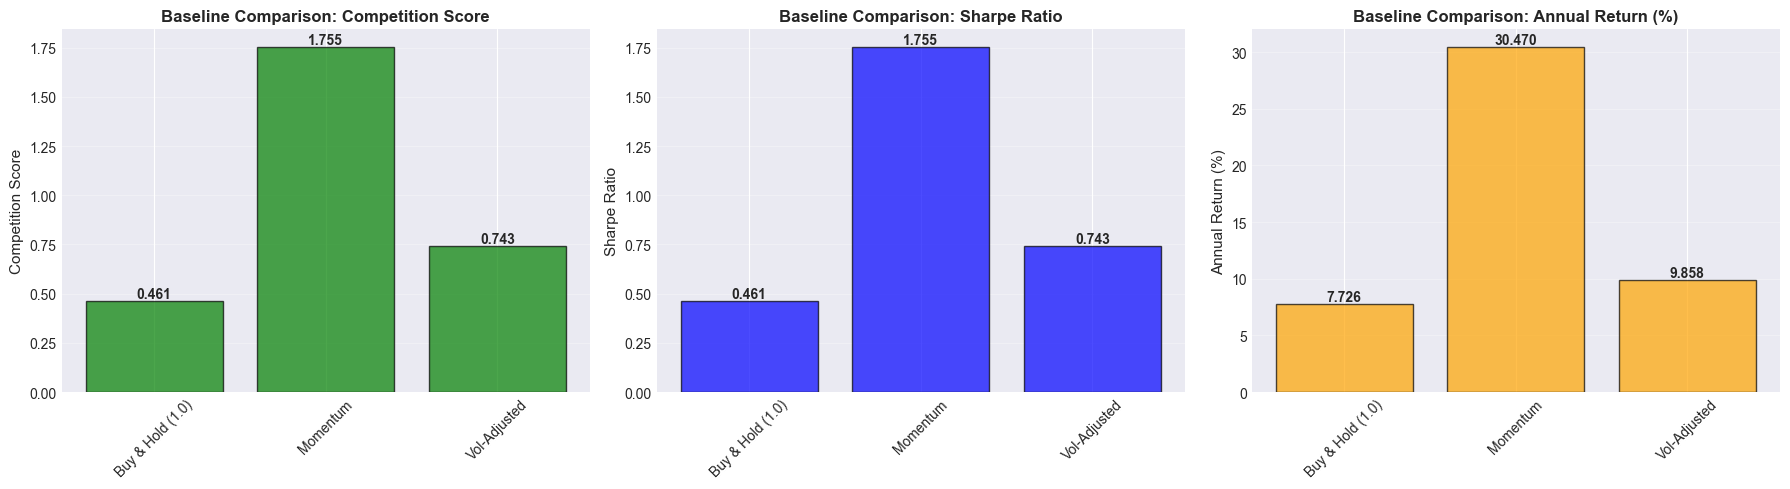

In [28]:
# Compare all baselines
comparison = pd.DataFrame({
    'Buy & Hold (1.0)': baseline_1,
    'Momentum': baseline_2,
    'Vol-Adjusted': baseline_3
}).T

print("\n" + "=" * 80)
print("BASELINE STRATEGY COMPARISON")
print("=" * 80)
print(comparison[['score', 'sharpe', 'strategy_volatility', 'strategy_annual_return', 
                  'vol_ratio', 'vol_penalty', 'return_penalty']].to_string())

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics_to_plot = [
    ('score', 'Competition Score', 'green'),
    ('sharpe', 'Sharpe Ratio', 'blue'),
    ('strategy_annual_return', 'Annual Return (%)', 'orange')
]

for idx, (metric, title, color) in enumerate(metrics_to_plot):
    values = comparison[metric].values
    strategies = comparison.index.tolist()
    
    bars = axes[idx].bar(strategies, values, color=color, alpha=0.7, edgecolor='black')
    axes[idx].set_ylabel(title, fontsize=11)
    axes[idx].set_title(f'Baseline Comparison: {title}', fontsize=12, fontweight='bold')
    axes[idx].grid(axis='y', alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=45)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        axes[idx].text(bar.get_x() + bar.get_width()/2., height,
                      f'{height:.3f}',
                      ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

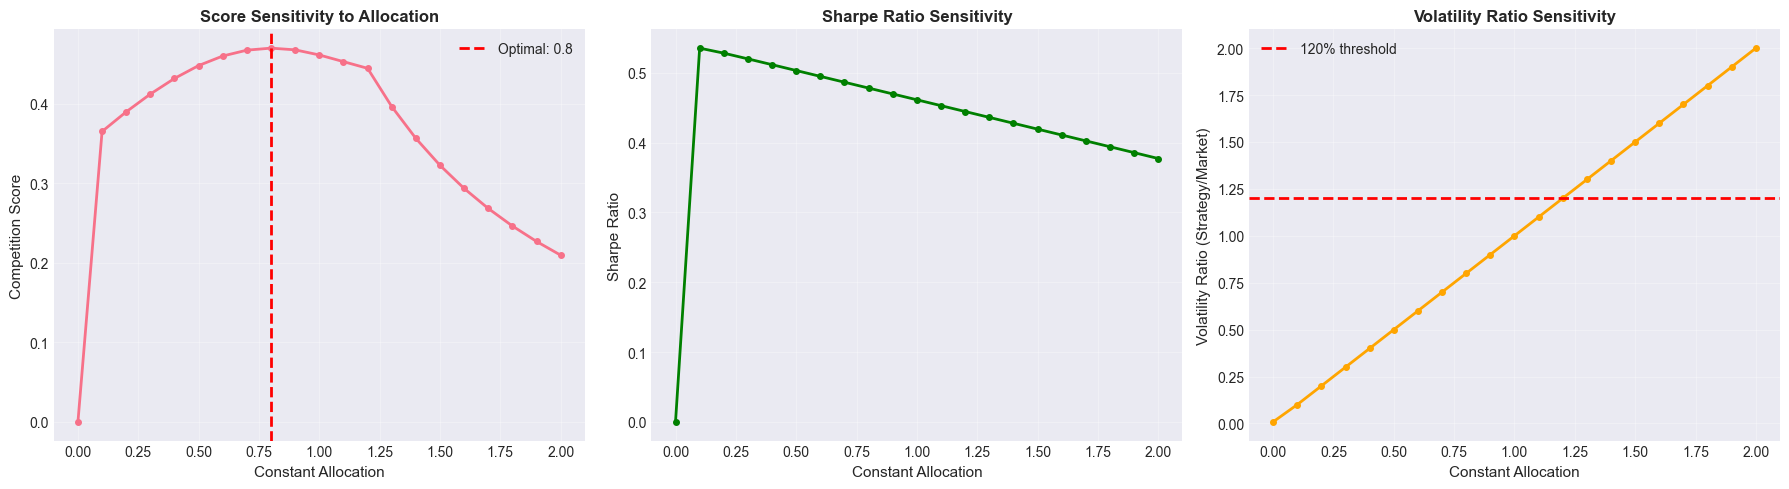


Optimal constant allocation: 0.8
Score at optimal allocation: 0.4699


In [29]:
# Sensitivity analysis: How does the score change with different constant allocations?
allocations = np.arange(0, 2.05, 0.1)
scores = []
sharpes = []
vol_ratios = []

for alloc in allocations:
    result = calculate_competition_score(
        train['forward_returns'].dropna(),
        train['risk_free_rate'].dropna(),
        alloc
    )
    if 'error' not in result:
        scores.append(result['score'])
        sharpes.append(result['sharpe'])
        vol_ratios.append(result['vol_ratio'])
    else:
        scores.append(np.nan)
        sharpes.append(np.nan)
        vol_ratios.append(np.nan)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Score vs allocation
axes[0].plot(allocations, scores, linewidth=2, marker='o', markersize=4)
best_idx = np.nanargmax(scores)
axes[0].axvline(allocations[best_idx], color='red', linestyle='--', linewidth=2, 
               label=f'Optimal: {allocations[best_idx]:.1f}')
axes[0].set_xlabel('Constant Allocation', fontsize=11)
axes[0].set_ylabel('Competition Score', fontsize=11)
axes[0].set_title('Score Sensitivity to Allocation', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Sharpe vs allocation
axes[1].plot(allocations, sharpes, linewidth=2, marker='o', markersize=4, color='green')
axes[1].set_xlabel('Constant Allocation', fontsize=11)
axes[1].set_ylabel('Sharpe Ratio', fontsize=11)
axes[1].set_title('Sharpe Ratio Sensitivity', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Vol ratio vs allocation
axes[2].plot(allocations, vol_ratios, linewidth=2, marker='o', markersize=4, color='orange')
axes[2].axhline(1.2, color='red', linestyle='--', linewidth=2, label='120% threshold')
axes[2].set_xlabel('Constant Allocation', fontsize=11)
axes[2].set_ylabel('Volatility Ratio (Strategy/Market)', fontsize=11)
axes[2].set_title('Volatility Ratio Sensitivity', fontsize=12, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nOptimal constant allocation: {allocations[best_idx]:.1f}")
print(f"Score at optimal allocation: {scores[best_idx]:.4f}")

## Summary and Next Steps

### Key Findings

1. **Data Quality**: 
   - Early data has ~85% missing values
   - Recent data is complete
   - Recommend using only recent complete data for initial models

2. **Target Characteristics**:
   - Daily returns are noisy with low autocorrelation
   - Volatility clustering exists (GARCH-like behavior)
   - Fat tails in return distribution

3. **Baseline Performance**:
   - Simple buy & hold achieves baseline score
   - Momentum and volatility strategies show promise
   - Room for improvement with ML models

### Recommended Next Steps

1. **Feature Engineering**:
   - Lag features (1, 5, 20, 60 days)
   - Rolling statistics
   - Volatility regime indicators
   - Momentum indicators

2. **Modeling Approaches**:
   - Start with tree-based models (LightGBM/XGBoost)
   - Try direct allocation prediction
   - Ensemble multiple strategies

3. **Validation Strategy**:
   - Use walk-forward validation
   - Monitor volatility constraint
   - Test on different market regimes